In [79]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn



In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [81]:
df1 = pd.read_csv('bitcoin_data_history1.csv')
df2 = pd.read_csv('bitcoin_data_history2.csv',on_bad_lines='skip')

df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

df2 = df2.drop(columns=[col for col in df2.columns if 'Unnamed' in col or col == ''])


In [82]:
import pandas as pd
import numpy as np

for col in df1.columns:
    if df1[col].dtype == 'int64':
        df2[col] = pd.to_numeric(df2[col], errors='coerce').fillna(0).astype(int)
    elif df1[col].dtype == 'float64':
        df2[col] = pd.to_numeric(df2[col], errors='coerce')  # Coerce invalid values to NaN
    else:
        df2[col] = df2[col].astype(df1[col].dtype)  # For any other type (shouldn't be in this case)



In [83]:

df_merged = pd.concat([df1, df2], axis=0).reset_index(drop=True)
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47933 entries, 0 to 47932
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              47933 non-null  int64  
 1   block_height           47933 non-null  int64  
 2   tx_count               47933 non-null  int64  
 3   mempool_size_mb        47932 non-null  float64
 4   min_fee_rate           47933 non-null  float64
 5   max_fee_rate           47933 non-null  float64
 6   avg_fee_rate           47933 non-null  float64
 7   median_fee_rate        47932 non-null  float64
 8   fee_rate_10th          47932 non-null  float64
 9   fee_rate_90th          47932 non-null  float64
 10  fee_rate_std           47932 non-null  float64
 11  block_time             47933 non-null  int64  
 12  difficulty             47932 non-null  float64
 13  hash_rate              47932 non-null  float64
 14  mempool_min_fee        47932 non-null  float64
 15  to

In [84]:
df=df_merged

In [85]:
# Convert 'block_time' to datetime
df['block_time'] = pd.to_datetime(df['block_time'], unit='s')

# Set 'block_time' as index
df.set_index('block_time', inplace=True)

In [86]:

def plot_boxplots(df, title):
    n_cols = len(df.columns)
    n_rows = (n_cols + 3) // 4  
    
    plt.figure(figsize=(20, 5 * n_rows))
    for i, column in enumerate(df.columns):
        plt.subplot(n_rows, 4, i+1)
        sns.boxplot(y=df[column])
        plt.title(column)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()




Original data shape: (47933, 21)
Removed 0 duplicate rows.

Columns with NaN values:
mempool_size_mb            1
median_fee_rate            1
fee_rate_10th              1
fee_rate_90th              1
fee_rate_std               1
difficulty                 1
hash_rate                  1
mempool_min_fee            1
total_fee                  1
block_interval             4
block_median_fee_rate    145
dtype: int64
No NaN values found after handling.


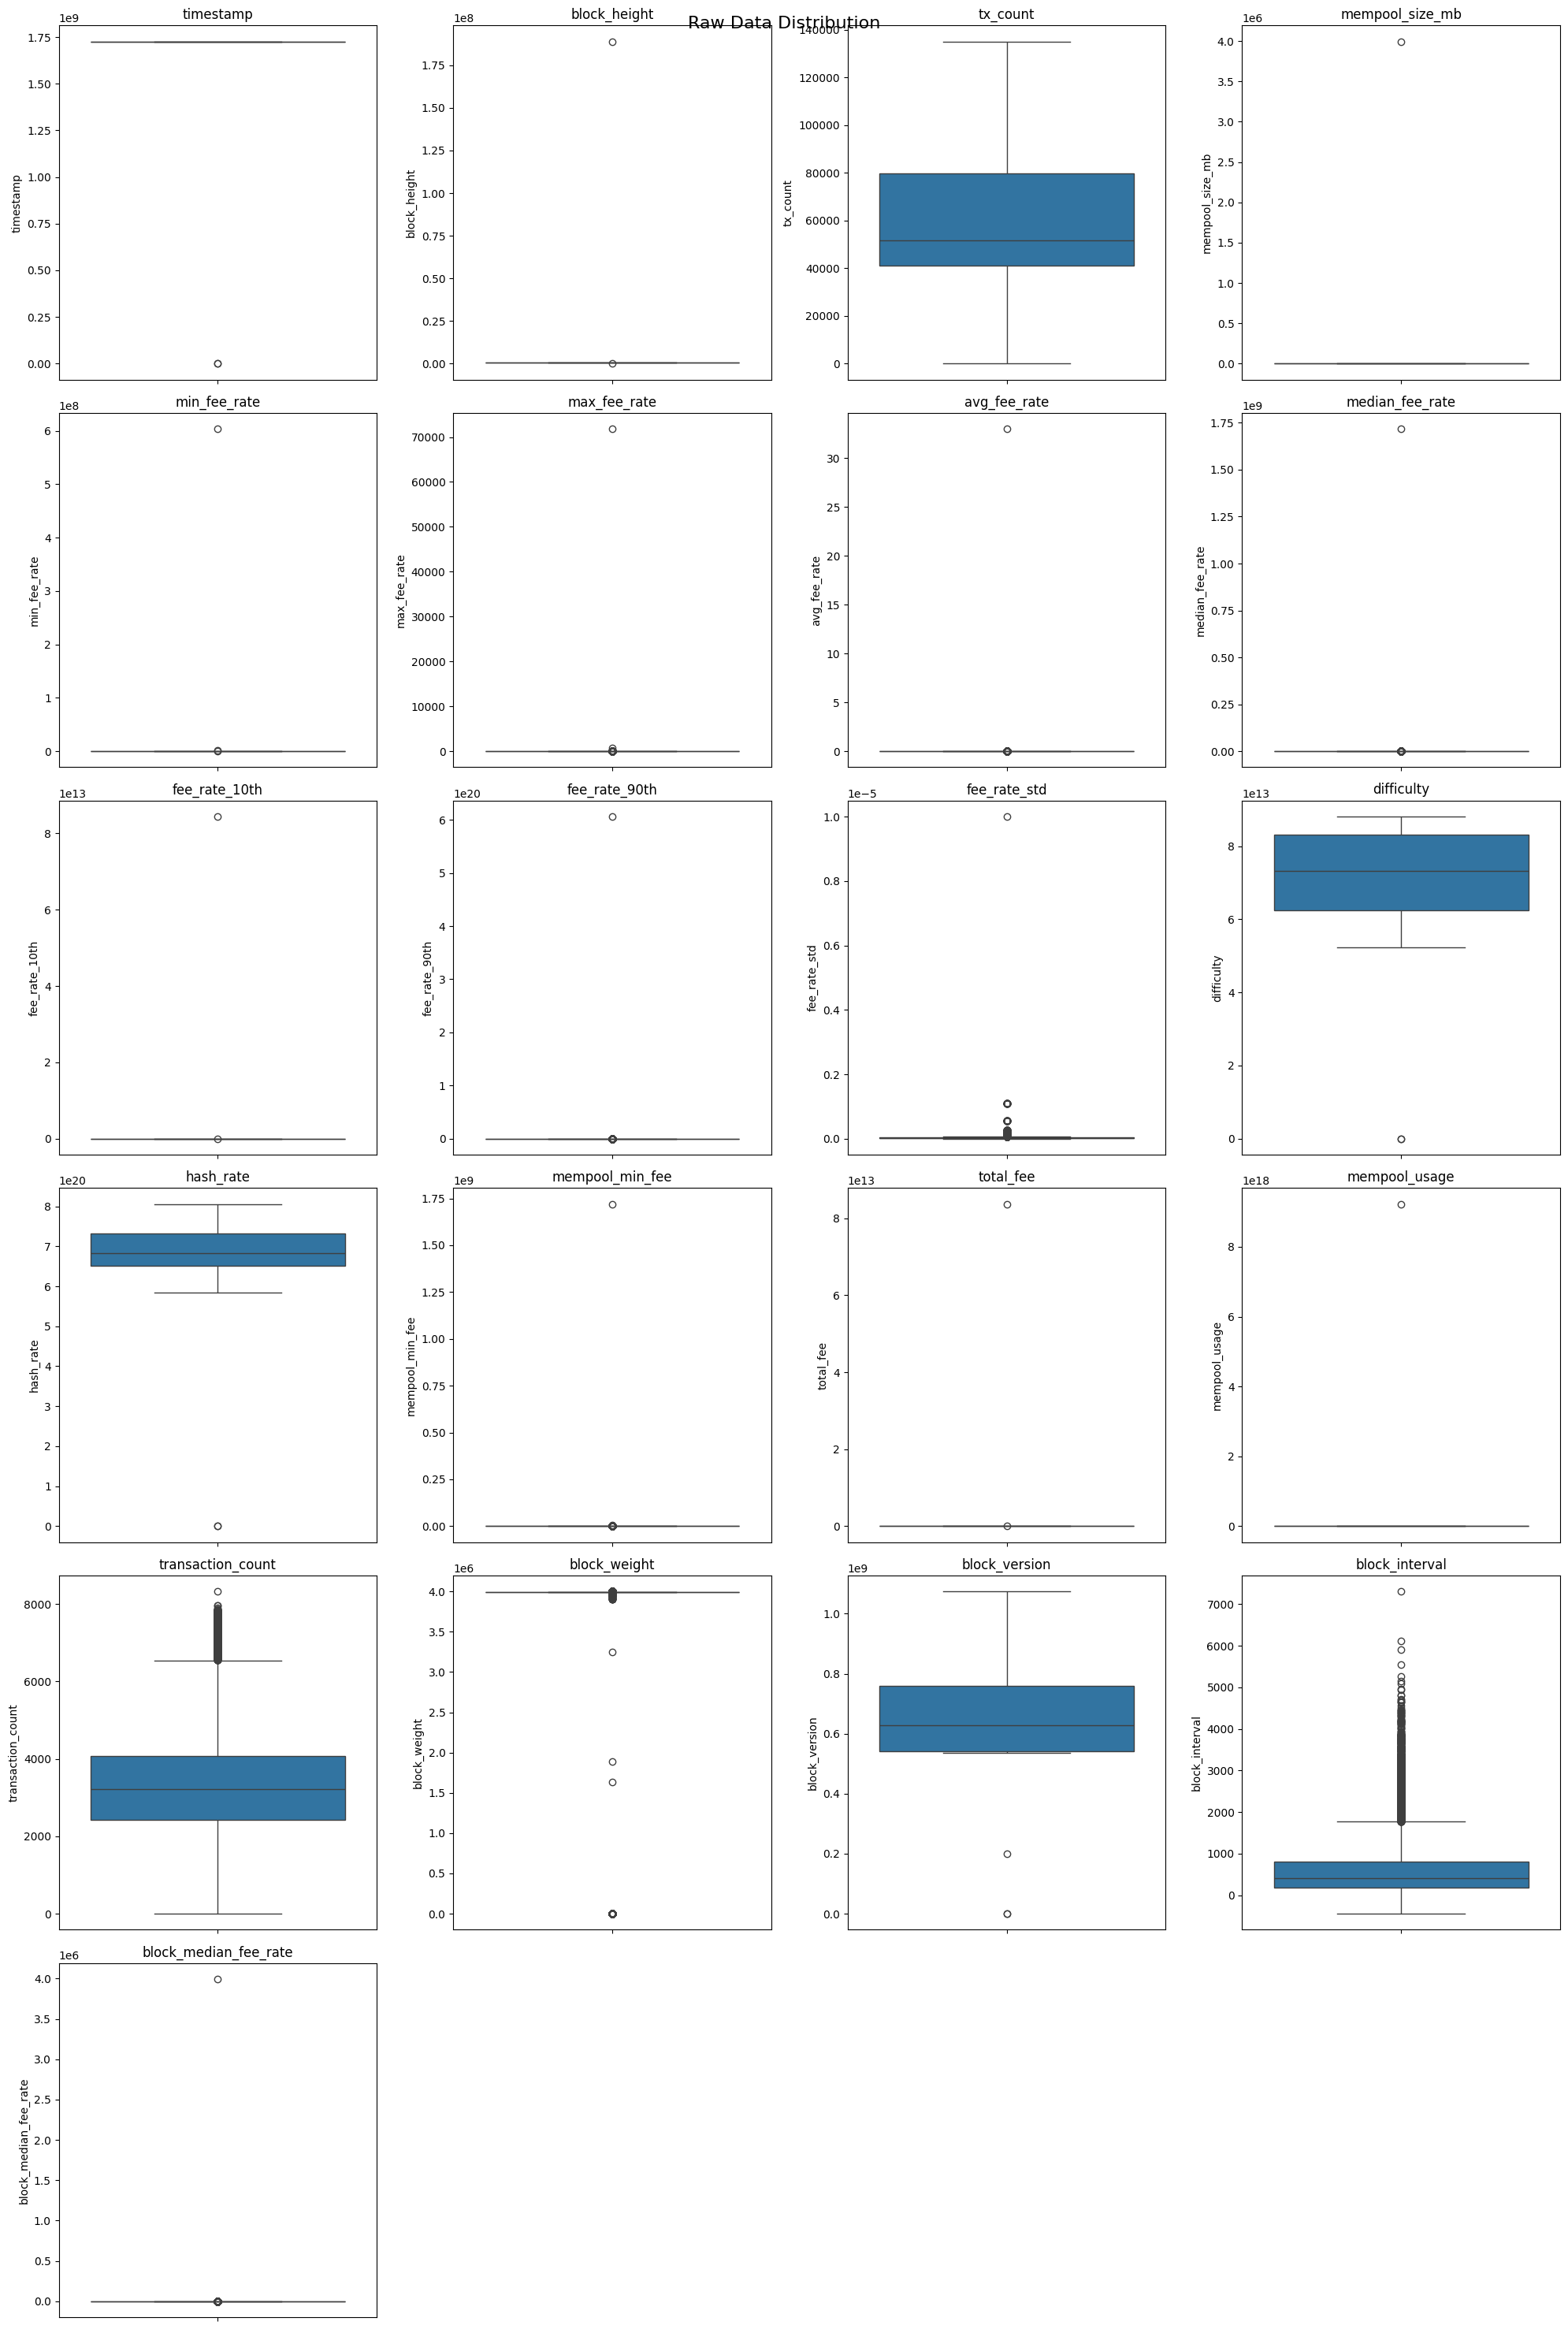

In [87]:
print("Original data shape:", df.shape)

duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removed {duplicates} duplicate rows.")

nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
if not columns_with_nan.empty:
    print("\nColumns with NaN values:")
    print(columns_with_nan)
    
    # Handle NaN values
    median_interval = df['block_interval'].median()  # Calculate median interval once
    for column in columns_with_nan.index:
        if column == 'block_interval':
            # For the first row, use the median interval. For others, forward fill.
            df['block_interval'] = df['block_interval'].ffill().fillna(median_interval)
        elif column == 'block_median_fee_rate':
            # Use forward fill, then backward fill for any remaining NaNs
            df[column] = df[column].ffill().bfill()
        elif column in ['mempool_size_mb', 'tx_count', 'mempool_usage']:
            # For mempool-related metrics, 0 might be appropriate if the mempool was empty
            df[column] = df[column].fillna(0)
        else:
            # For other columns, use forward fill, then backward fill
            df[column] = df[column].ffill().bfill()

    remaining_nans = df.isna().sum()[df.isna().sum() > 0]
    if not remaining_nans.empty:
        print("\nRemaining NaN values after handling:")
        print(remaining_nans)
    else:
        print("No NaN values found after handling.")
else:
    print("No NaN values found.")

# If there are still any NaN values, drop those rows
rows_before = df.shape[0]
df = df.dropna()
rows_after = df.shape[0]
if rows_before > rows_after:
    print(f"\nDropped {rows_before - rows_after} rows with remaining NaN values.")


if df.empty:
    print("Warning: DataFrame is empty after cleaning. Please check the data processing steps.")
else:
    # Plotting the distribution of the cleaned data
    plot_boxplots(df, "Raw Data Distribution")


Interpreting the Boxplots:
Boxplots are a way to visualize the distribution of data in each column of your DataFrame. Here's a guide on how to interpret the elements and axes of the boxplots:

Key Components of a Boxplot:

The Box:

The main body of the plot (the box) represents the interquartile range (IQR), which is the range between the 25th percentile (Q1) and the 75th percentile (Q3) of the data.

The line inside the box represents the median (50th percentile).

Whiskers:

The lines (whiskers) extending from the box show the range of the data, typically 1.5 times the IQR. Points outside of this range are considered potential outliers.
Outliers:

The dots beyond the whiskers represent outliers, which are values that fall significantly above or below the majority of the data.

Axes:

Y-axis (Values): Represents the actual values of the column. Since these boxplots are vertical, the Y-axis shows the numeric range of the data for each column.

X-axis: There is no X-axis label in this case because these are individual boxplots for each column of the dataset.


block_height:

The boxplot for block_height seems problematic since it is heavily skewed (a very large range and outliers). The whiskers are likely compressed due to outliers, indicating that the distribution is not normal. Most of the data is near the bottom, with a few extreme values.

Action: Further investigation into these extreme values is needed. Check for possible errors, outliers, or inconsistencies in the block_height column.

tx_count:

This distribution looks more typical, with a relatively large IQR and some outliers. The majority of the data seems to cluster around the lower range, with a few higher outliers.

mempool_size_mb:

This column appears to have significant outliers, as most of the data is clustered near the bottom, but there is one extreme value.

Action: Investigate whether this extreme value is valid or if it needs to be handled (e.g., corrected, removed, or imputed).

min_fee_rate, max_fee_rate, avg_fee_rate, median_fee_rate:

The distribution of fee rates appears heavily skewed with possible outliers. Most data points are near zero, with a few large values pulling the distribution upward.

Action: Explore why the fee rates are concentrated near zero. This could be due to the nature of the data (e.g., rare high fees), but further analysis is needed.

Other Columns:

Similar to the observations above, most of the columns exhibit skewness and possible outliers. These columns may require further preprocessing, such as normalizing or transforming the data to better represent their distribution for analysis.

Checking the block_height Feature for Consecutiveness:

The block_height feature should be consecutive, meaning there should be no missing or out-of-sequence values. From the earlier boxplot, the distribution of block_height suggests potential issues, as it appears skewed and not normally distributed. Given this, it’s important to verify that the block_height values follow a proper consecutive sequence, without any gaps or irregularities.

To investigate this, we will:

Sort the block_height values to ensure they are in the correct order.

Calculate the difference between consecutive values to detect any gaps (differences greater than 1).
Analyze the results to confirm whether the values are sequential or identify where gaps occur.

By doing this, we can determine if the unusual distribution of block_height is due to missing or incorrectly ordered values, which may need further handling in the data preprocessing steps.

In [88]:
# Calculate the difference between consecutive block_height values to find any anomalies
df['block_height_diff'] = df['block_height'].diff()

# Look for large jumps in block_height (should typically be 1)
anomalies = df[df['block_height_diff'] > 1]
print(f"Found {len(anomalies)} anomalies in block_height increments:")
print(anomalies[['block_height', 'block_height_diff']])


Found 4 anomalies in block_height increments:
                     block_height  block_height_diff
block_time                                          
2024-07-23 18:10:47        853599             8869.0
2024-05-24 20:20:58        844971           844971.0
2024-06-30 11:38:46        850099             5097.0
1970-01-01 00:00:00     188893824        188040227.0


In [89]:
# Remove the row with the extreme block_height outlier

# Manually filter out the problematic block_height values
df_cleaned = df[(df['block_height'] != 188893824) & 
                (df['block_height'] != 853599) & 
                (df['block_height'] != 844971) & 
                (df['block_height'] != 850099)]


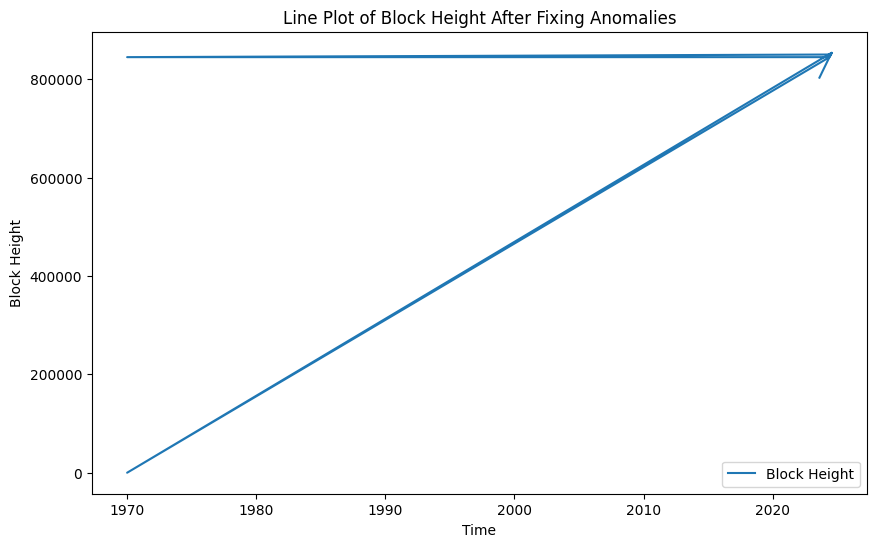

In [90]:
# Visualize the cleaned block_height
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['block_height'], label='Block Height')
plt.title("Line Plot of Block Height After Fixing Anomalies")
plt.xlabel("Time")
plt.ylabel("Block Height")
plt.legend()
plt.show()



<Axes: ylabel='block_height'>

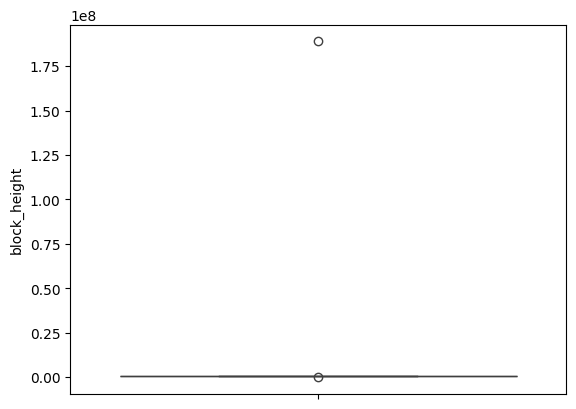

In [91]:
 sns.boxplot(y=df['block_height'])

column block_height still exist outlier, so continue the clean

In [92]:
# Check the minimum and maximum dates
print("Min block_time:", df_cleaned.index.min())
print("Max block_time:", df_cleaned.index.max())

# Check how many rows have '1970-01-01' as the block_time
invalid_dates = df_cleaned[df_cleaned.index == '1970-01-01']
print(f"Found {len(invalid_dates)} rows with the invalid date '1970-01-01'")


Min block_time: 1970-01-01 00:00:00
Max block_time: 2024-07-26 07:21:06
Found 2 rows with the invalid date '1970-01-01'


In [93]:
# Remove rows with invalid block_time
df_cleaned = df_cleaned[df_cleaned.index != '1970-01-01']


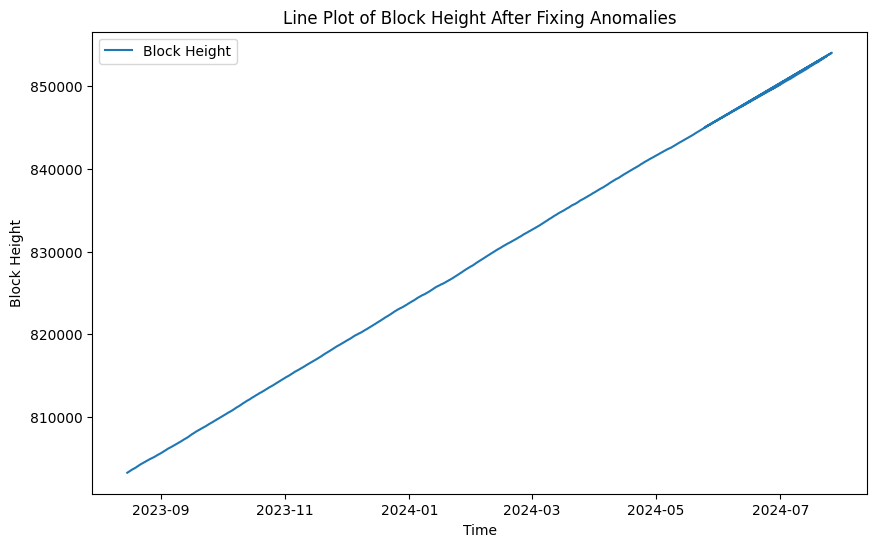

In [94]:
# Visualize the cleaned block_height
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['block_height'], label='Block Height')
plt.title("Line Plot of Block Height After Fixing Anomalies")
plt.xlabel("Time")
plt.ylabel("Block Height")
plt.legend()
plt.show()


<Axes: ylabel='block_height'>

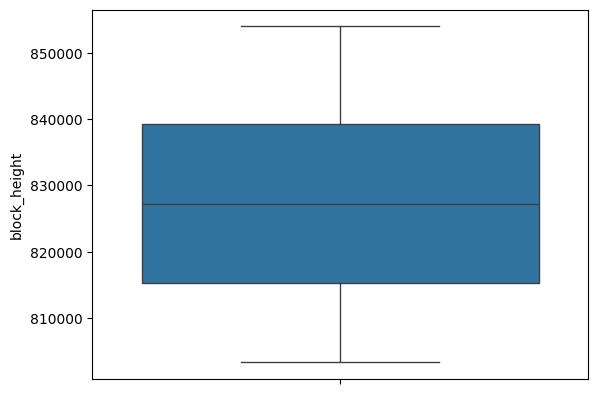

In [95]:
 sns.boxplot(y=df_cleaned['block_height'])

In [96]:
df_cleaned.shape

(47927, 22)

In [97]:
# Remove duplicate block_height values and keep only the first occurrence
df_cleaned = df_cleaned.drop_duplicates(subset=['block_height'], keep='first')

# Print the shape of the DataFrame after removing duplicates
print(f"Shape of the DataFrame after removing duplicates: {df_cleaned.shape}")


Shape of the DataFrame after removing duplicates: (47926, 22)


In [98]:
# Check for duplicate values in the block_height column
duplicate_block_heights = df_cleaned[df_cleaned['block_height'].duplicated(keep=False)]

# Print the duplicate block heights
print(f"Number of duplicate block heights: {len(duplicate_block_heights)}")
print(duplicate_block_heights[['block_height']])

Number of duplicate block heights: 0
Empty DataFrame
Columns: [block_height]
Index: []


In [99]:
# Check for duplicate index values
duplicate_indices = df_cleaned.index.duplicated(keep=False)

# Print the number of duplicate index values
print(f"Number of duplicate indices: {duplicate_indices.sum()}")

# Show the rows with duplicate indices
df_duplicates = df_cleaned[duplicate_indices]
print(df_duplicates)


Number of duplicate indices: 14
                      timestamp  block_height  tx_count  mempool_size_mb  \
block_time                                                                 
2023-12-24 21:24:33  1725323273        822786    116122        41.239090   
2023-12-24 21:24:33  1725323309        822788    116202        41.260115   
2024-01-31 09:12:40  1725387592        828225    127760        44.883422   
2024-01-31 09:12:40  1725387603        828226    127789        44.890101   
2024-02-23 13:52:32  1725504098        831690     53332         8.005034   
2024-02-23 13:52:32  1725504120        831691     53794         8.084864   
2024-02-26 15:58:50  1725508728        832145     53821         9.285521   
2024-02-26 15:58:50  1725508735        832146     53831         9.287004   
2024-03-25 10:42:34  1725535947        836232     31290         9.089303   
2024-03-25 10:42:34  1725535952        836233     31443         9.109860   
2024-06-15 15:16:41  1725658165        848041     64208 

In [100]:
# Drop duplicate index rows
df_cleaned = df_cleaned[~df_cleaned.index.duplicated(keep='first')]

# Recheck if duplicates remain
print(f"Number of remaining duplicate indices: {df_cleaned.index.duplicated().sum()}")


Number of remaining duplicate indices: 0


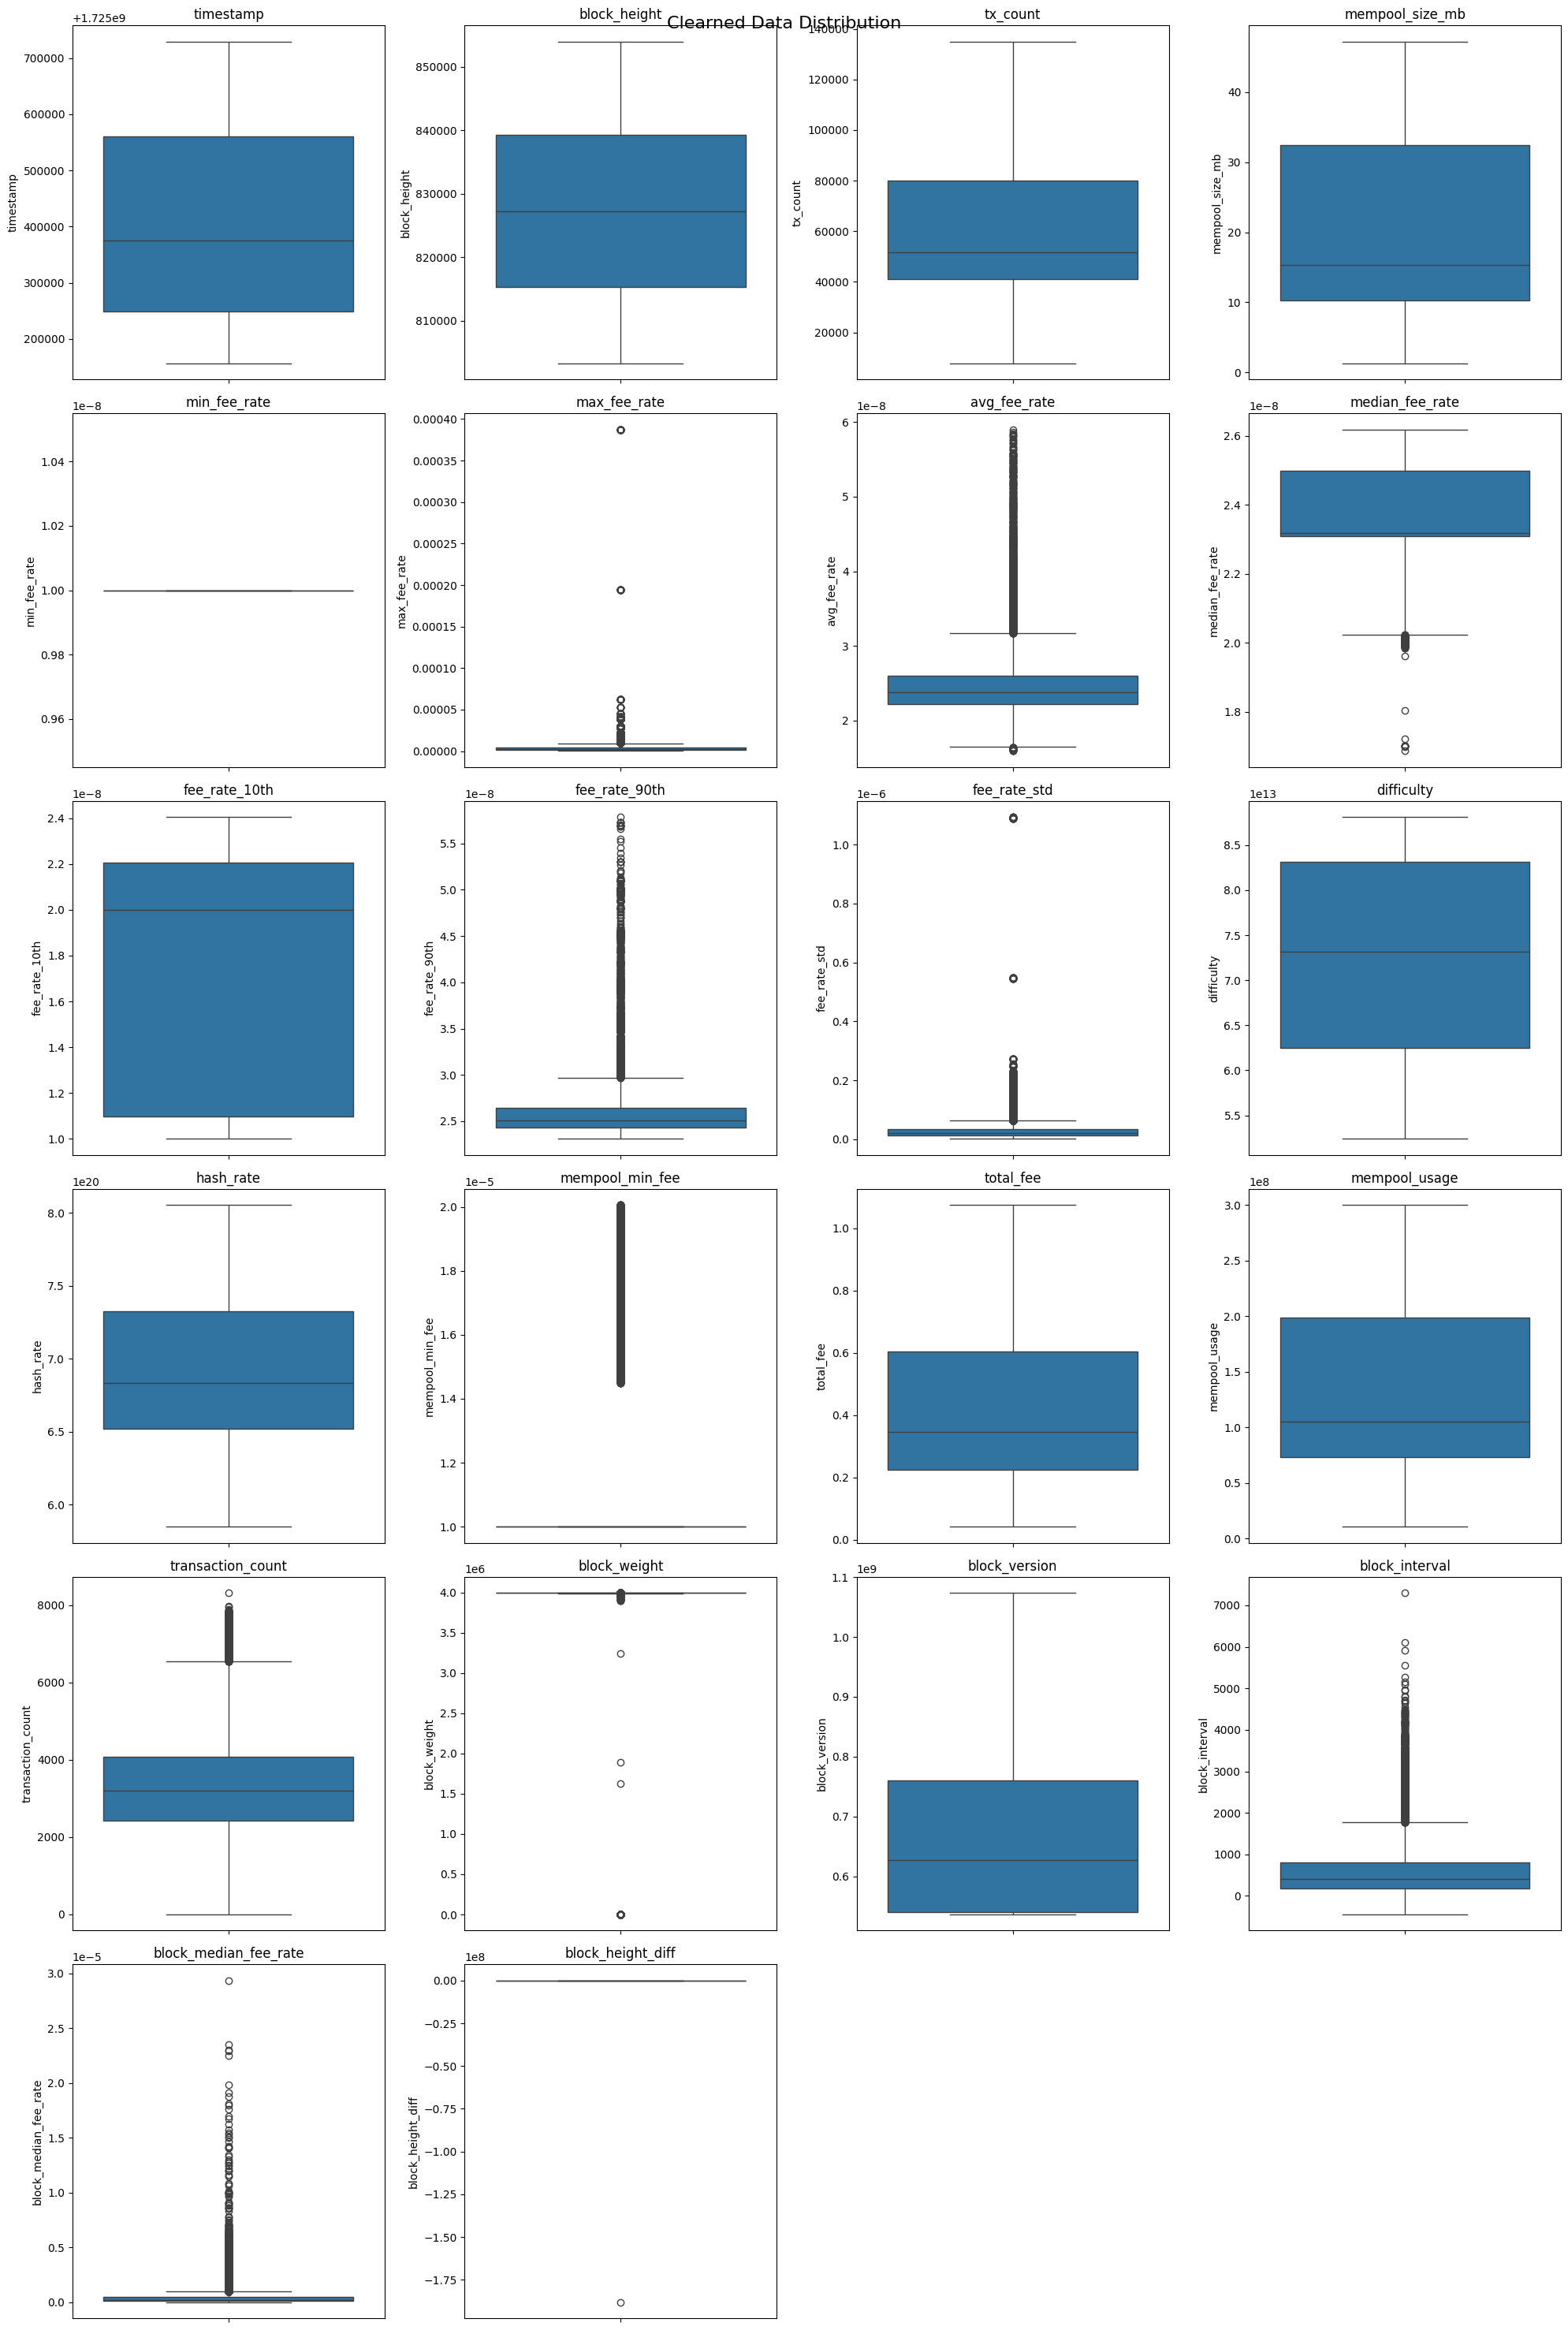

In [101]:

plot_boxplots(df_cleaned, "Clearned Data Distribution")

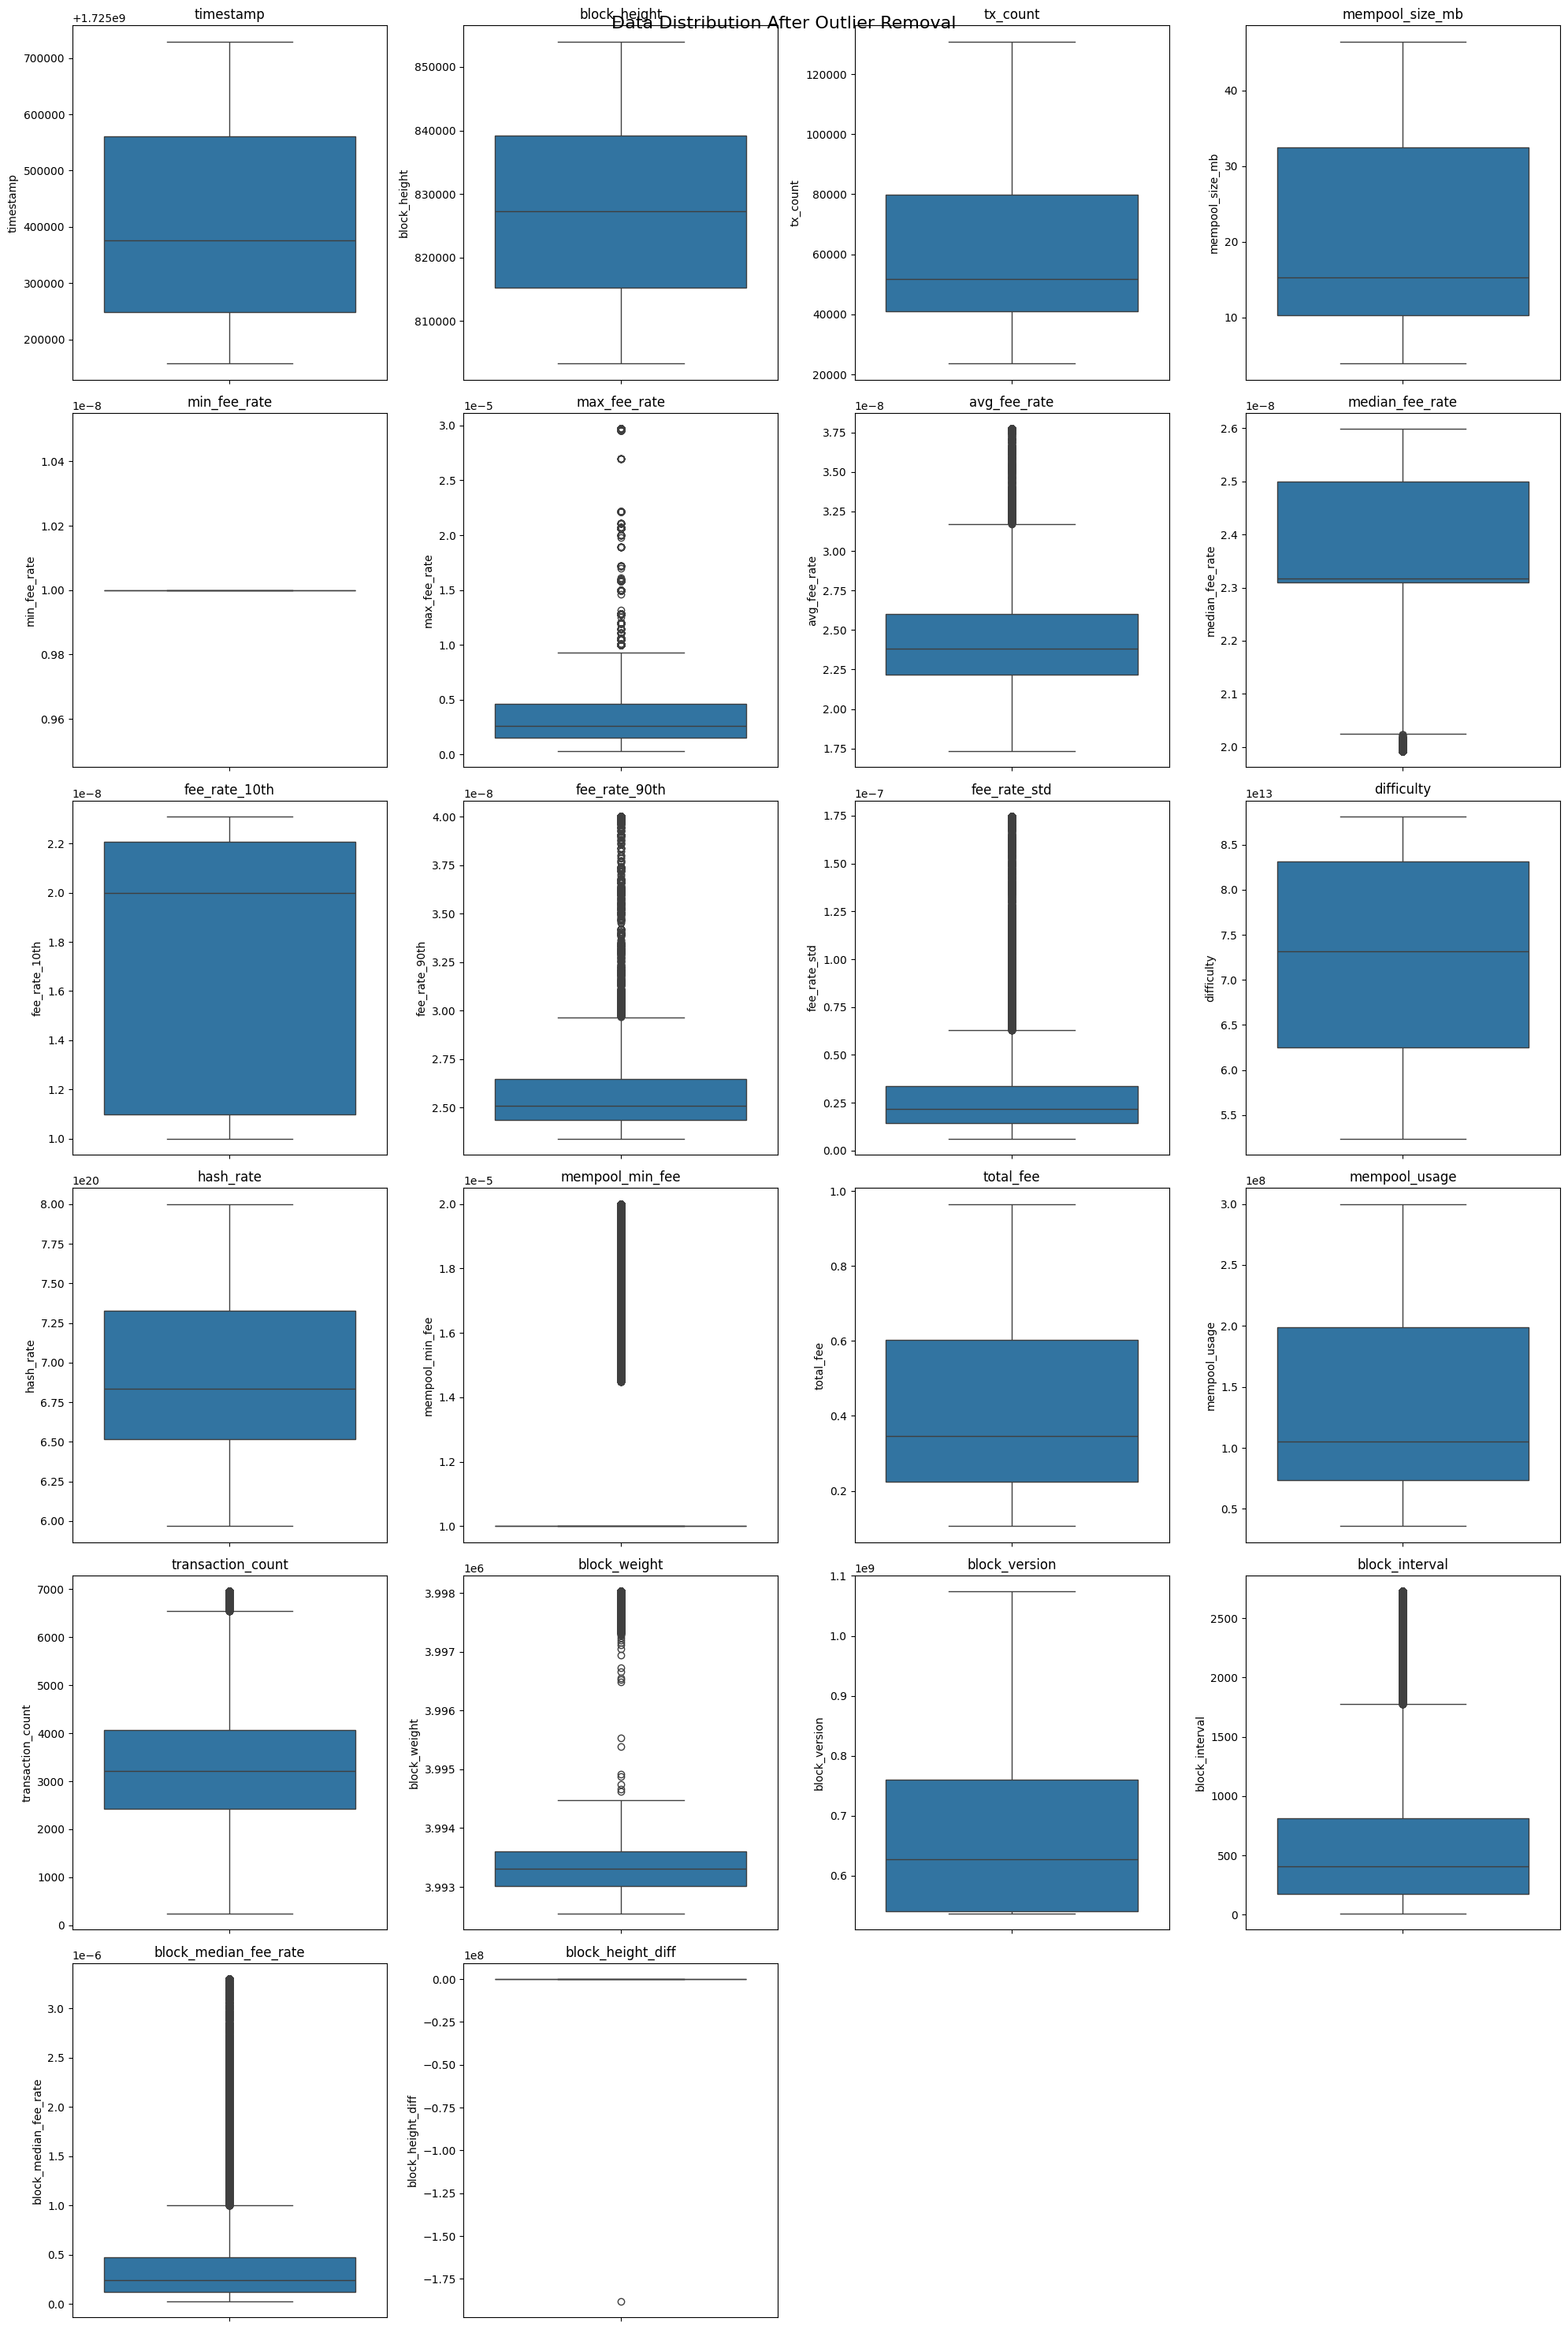

In [102]:
# Define a function to remove outliers by clipping based on percentiles
def handle_outliers(data, column, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(data[column], lower_percentile)
    upper = np.percentile(data[column], upper_percentile)
    data[column] = data[column].clip(lower, upper)
    return data

# Remove outliers for all columns except for 'block_height', 'timestamp', and 'difficulty'
for column in df_cleaned.columns:
    if column not in ['block_height', 'timestamp', 'difficulty']:  # Exclude these columns
        df_cleaned = handle_outliers(df_cleaned, column)


plot_boxplots(df_cleaned, "Data Distribution After Outlier Removal")


In [103]:
# Remove 'block_height_diff' and 'min_fee_rate' columns from df_cleaned
df_cleaned = df_cleaned.drop(columns=['block_height_diff', 'min_fee_rate'])

print(df_cleaned.columns)


Index(['timestamp', 'block_height', 'tx_count', 'mempool_size_mb',
       'max_fee_rate', 'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th',
       'fee_rate_90th', 'fee_rate_std', 'difficulty', 'hash_rate',
       'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
       'block_weight', 'block_version', 'block_interval',
       'block_median_fee_rate'],
      dtype='object')


In [104]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47919 entries, 2023-08-15 13:04:26 to 2024-06-30 11:25:16
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              47919 non-null  int64  
 1   block_height           47919 non-null  int64  
 2   tx_count               47919 non-null  float64
 3   mempool_size_mb        47919 non-null  float64
 4   max_fee_rate           47919 non-null  float64
 5   avg_fee_rate           47919 non-null  float64
 6   median_fee_rate        47919 non-null  float64
 7   fee_rate_10th          47919 non-null  float64
 8   fee_rate_90th          47919 non-null  float64
 9   fee_rate_std           47919 non-null  float64
 10  difficulty             47919 non-null  float64
 11  hash_rate              47919 non-null  float64
 12  mempool_min_fee        47919 non-null  float64
 13  total_fee              47919 non-null  float64
 14  mempool_usage      

In [105]:
print("\nSummary statistics of raw data:")
print(df.describe())

print("\nSummary statistics of cleaned data:")
print(df_cleaned.describe())

# df_cleaned.to_csv('bitcoin_data_cleaned.csv')
# print("Cleaned data saved to 'bitcoin_data_cleaned.csv'")



Summary statistics of raw data:
          timestamp  block_height       tx_count  mempool_size_mb  \
count  4.793300e+04  4.793300e+04   47933.000000     4.793300e+04   
mean   1.725341e+09  8.315433e+05   64789.984082     1.045537e+02   
std    1.114655e+07  8.591298e+05   32241.747510     1.823757e+04   
min    0.000000e+00  0.000000e+00       0.000000     0.000000e+00   
25%    1.725248e+09  8.152810e+05   40993.000000     1.024717e+01   
50%    1.725376e+09  8.272640e+05   51790.000000     1.529292e+01   
75%    1.725560e+09  8.392460e+05   79882.000000     3.250172e+01   
max    1.725729e+09  1.888938e+08  134999.000000     3.992883e+06   

       min_fee_rate  max_fee_rate  avg_fee_rate  median_fee_rate  \
count  4.793300e+04  4.793300e+04  4.793300e+04     4.793300e+04   
mean   1.260713e+04  1.510967e+00  6.877893e-04     3.581211e+04   
std    2.756274e+06  3.278624e+02  1.505766e-01     7.840563e+06   
min    1.000000e-08  2.507937e-08  1.592778e-08     1.000000e-08   
25%  

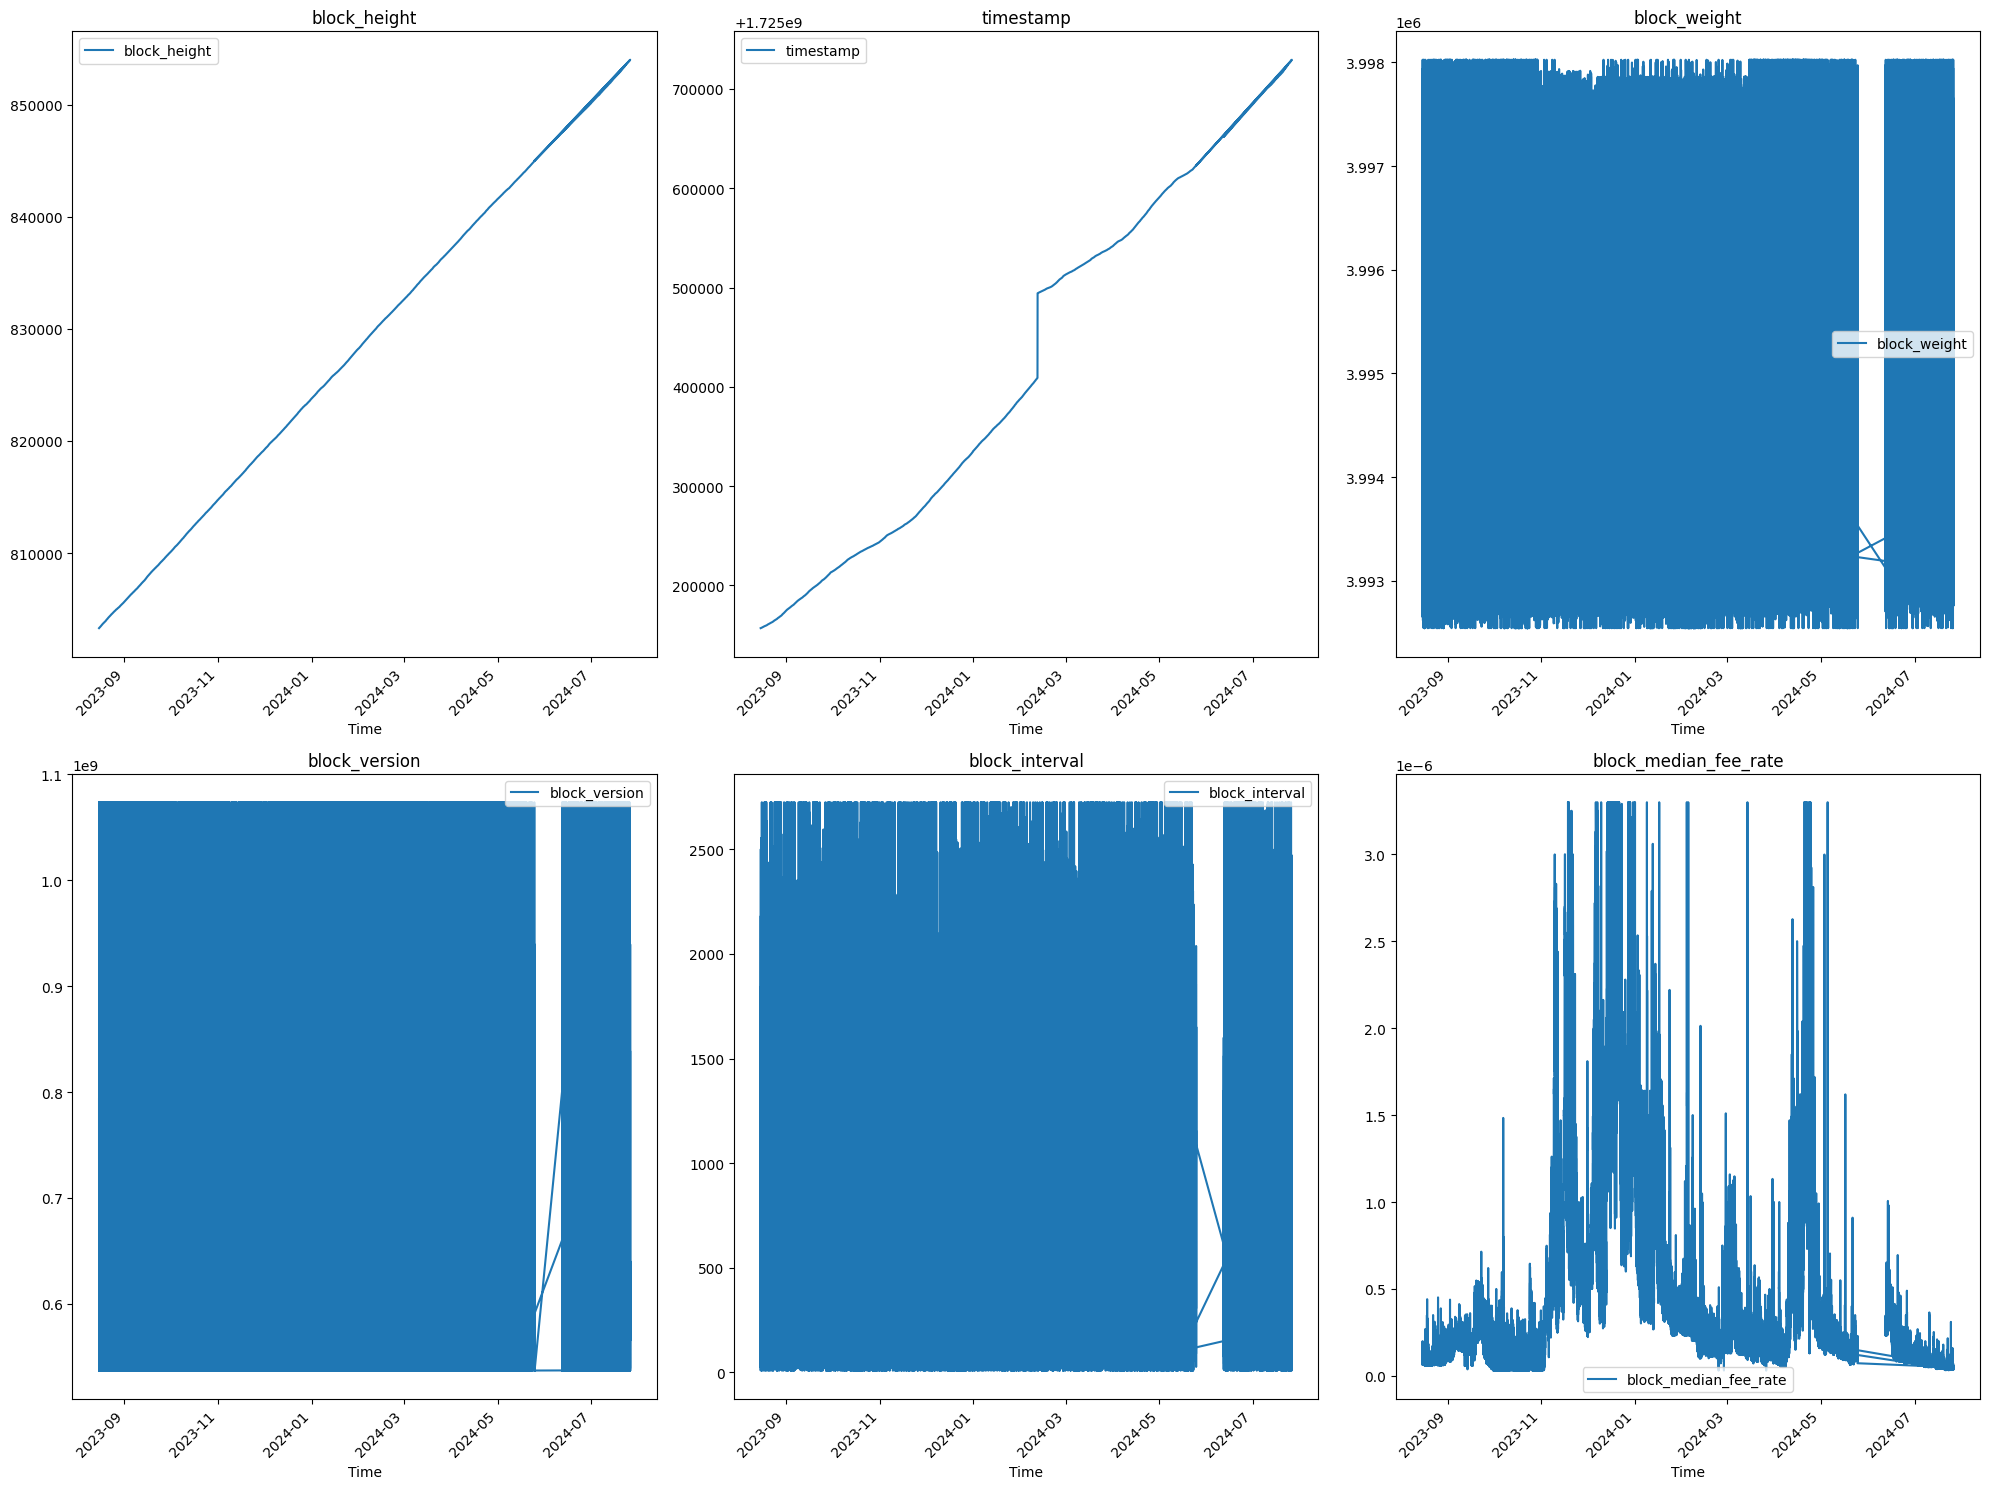

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series(df, features, rows=3, cols=3, figsize=(20, 15)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() 
    
    for i, feature in enumerate(features):
        if i < len(axes) and feature in df.columns:
            ax = axes[i]
            df.plot(y=feature, ax=ax)
            ax.set_title(feature)
            ax.set_xlabel('Time')
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Update these lists based on the columns actually present in df_cleaned
block_features = ['block_height', 'timestamp', 'block_weight', 'block_version', 'block_interval','block_median_fee_rate','difficulty']
transaction_features = ['tx_count', 'transaction_count', 'total_fee']
fee_features = ['min_fee_rate', 'max_fee_rate', 'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'block_median_fee_rate']
mempool_features = ['mempool_size_mb', 'mempool_min_fee', 'mempool_usage']
network_features = ['difficulty', 'hash_rate']


plot_time_series(df_cleaned, block_features,rows=2, cols=3)



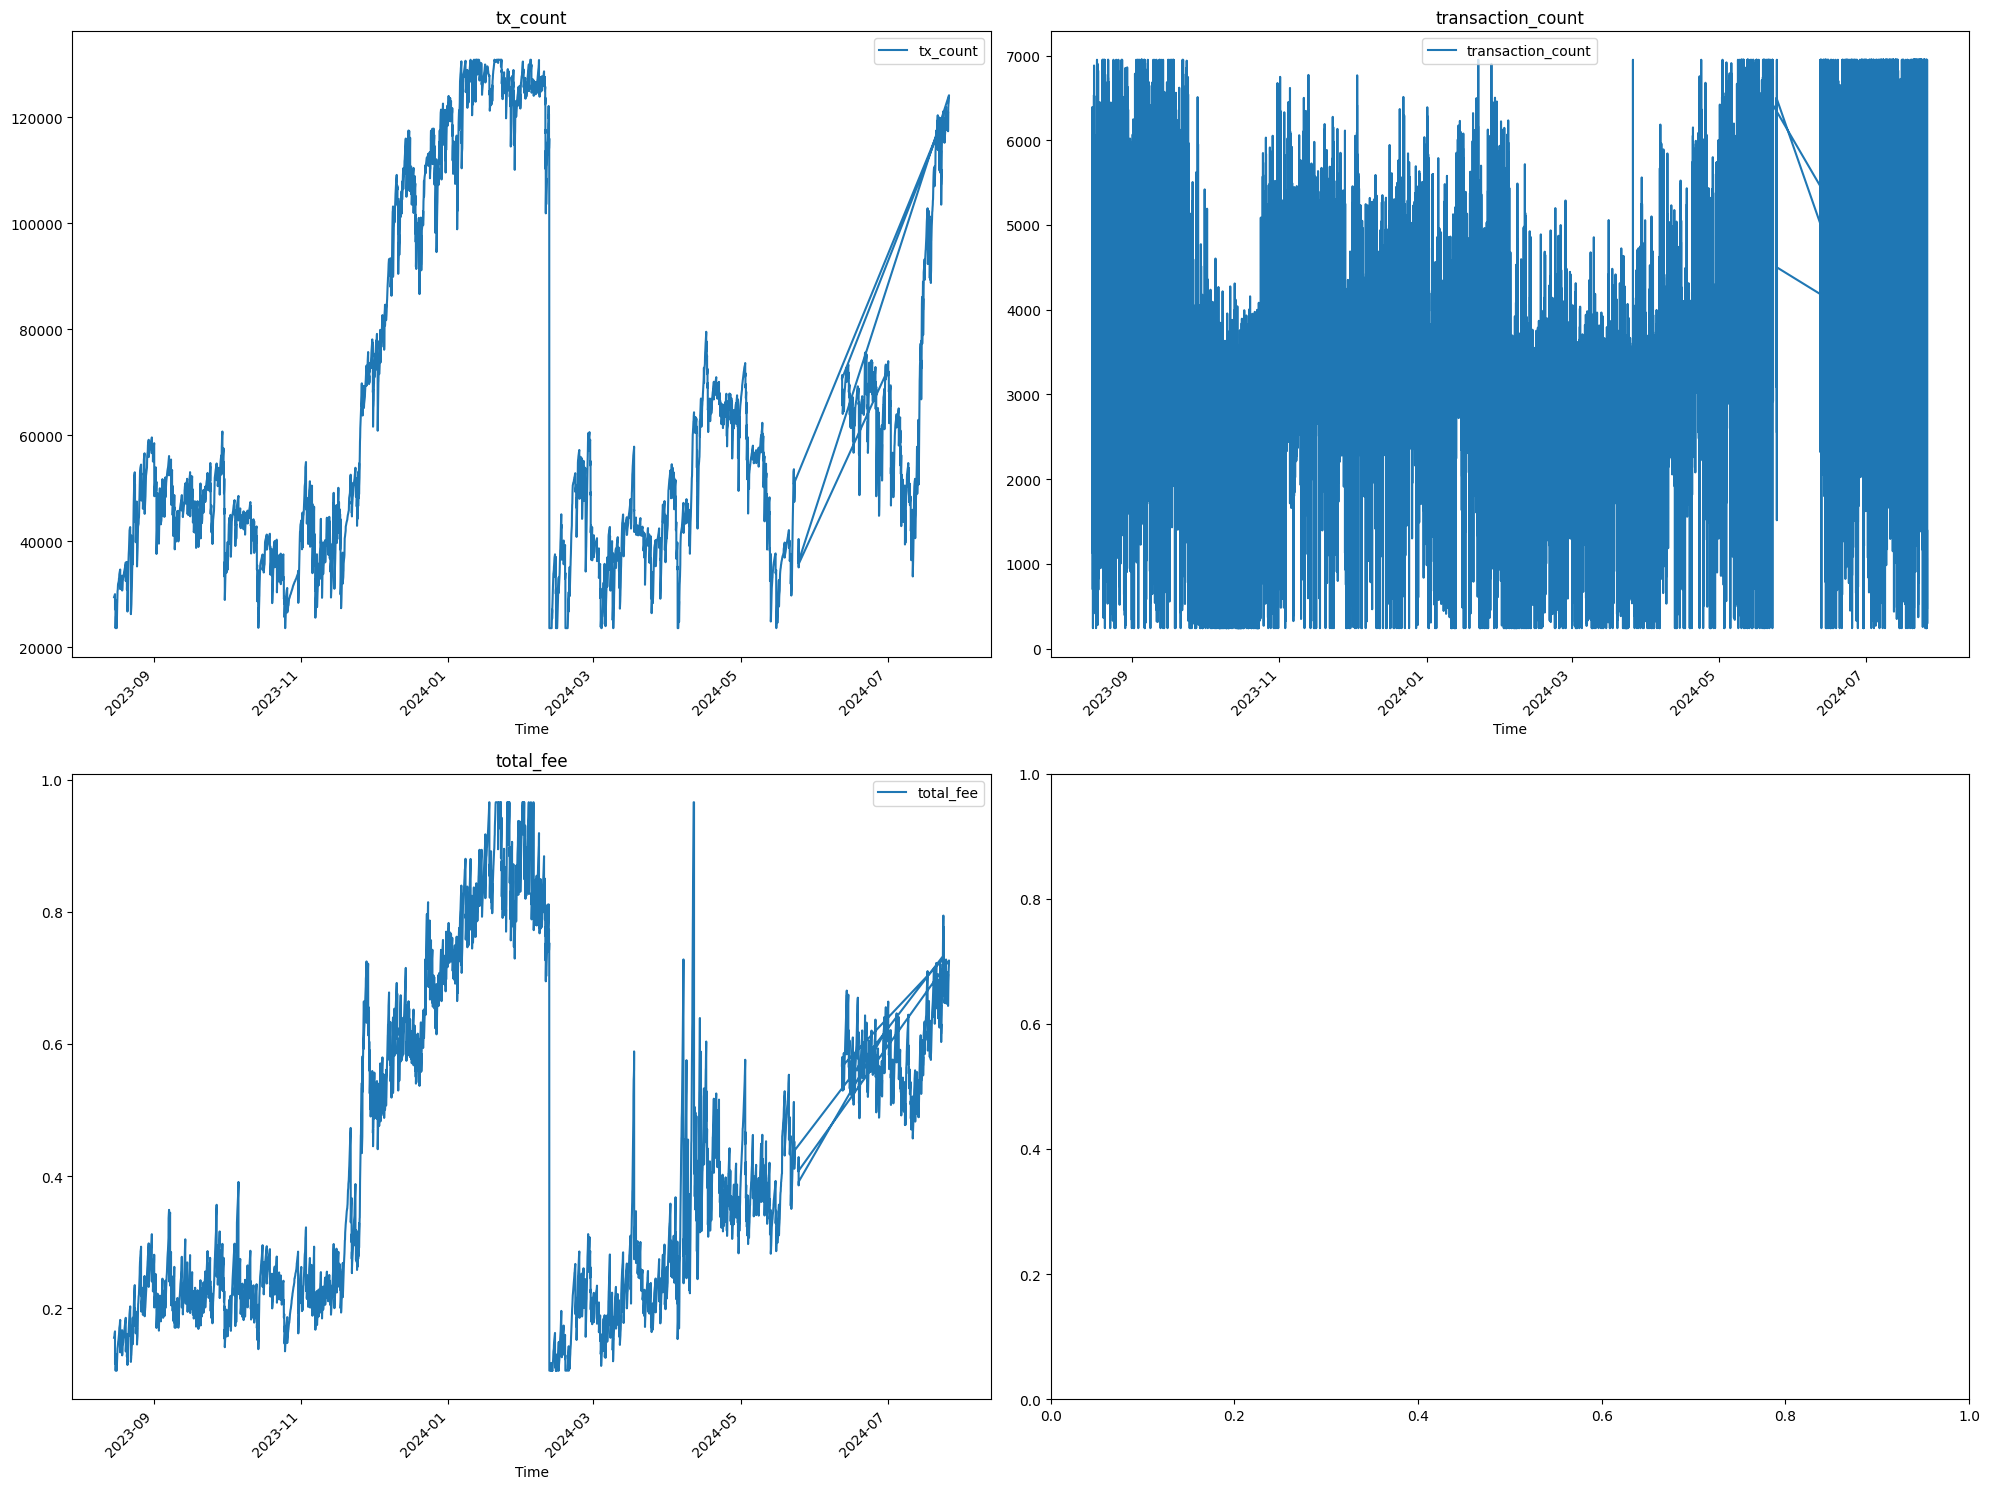

In [107]:
plot_time_series(df_cleaned, transaction_features,rows=2, cols=2)

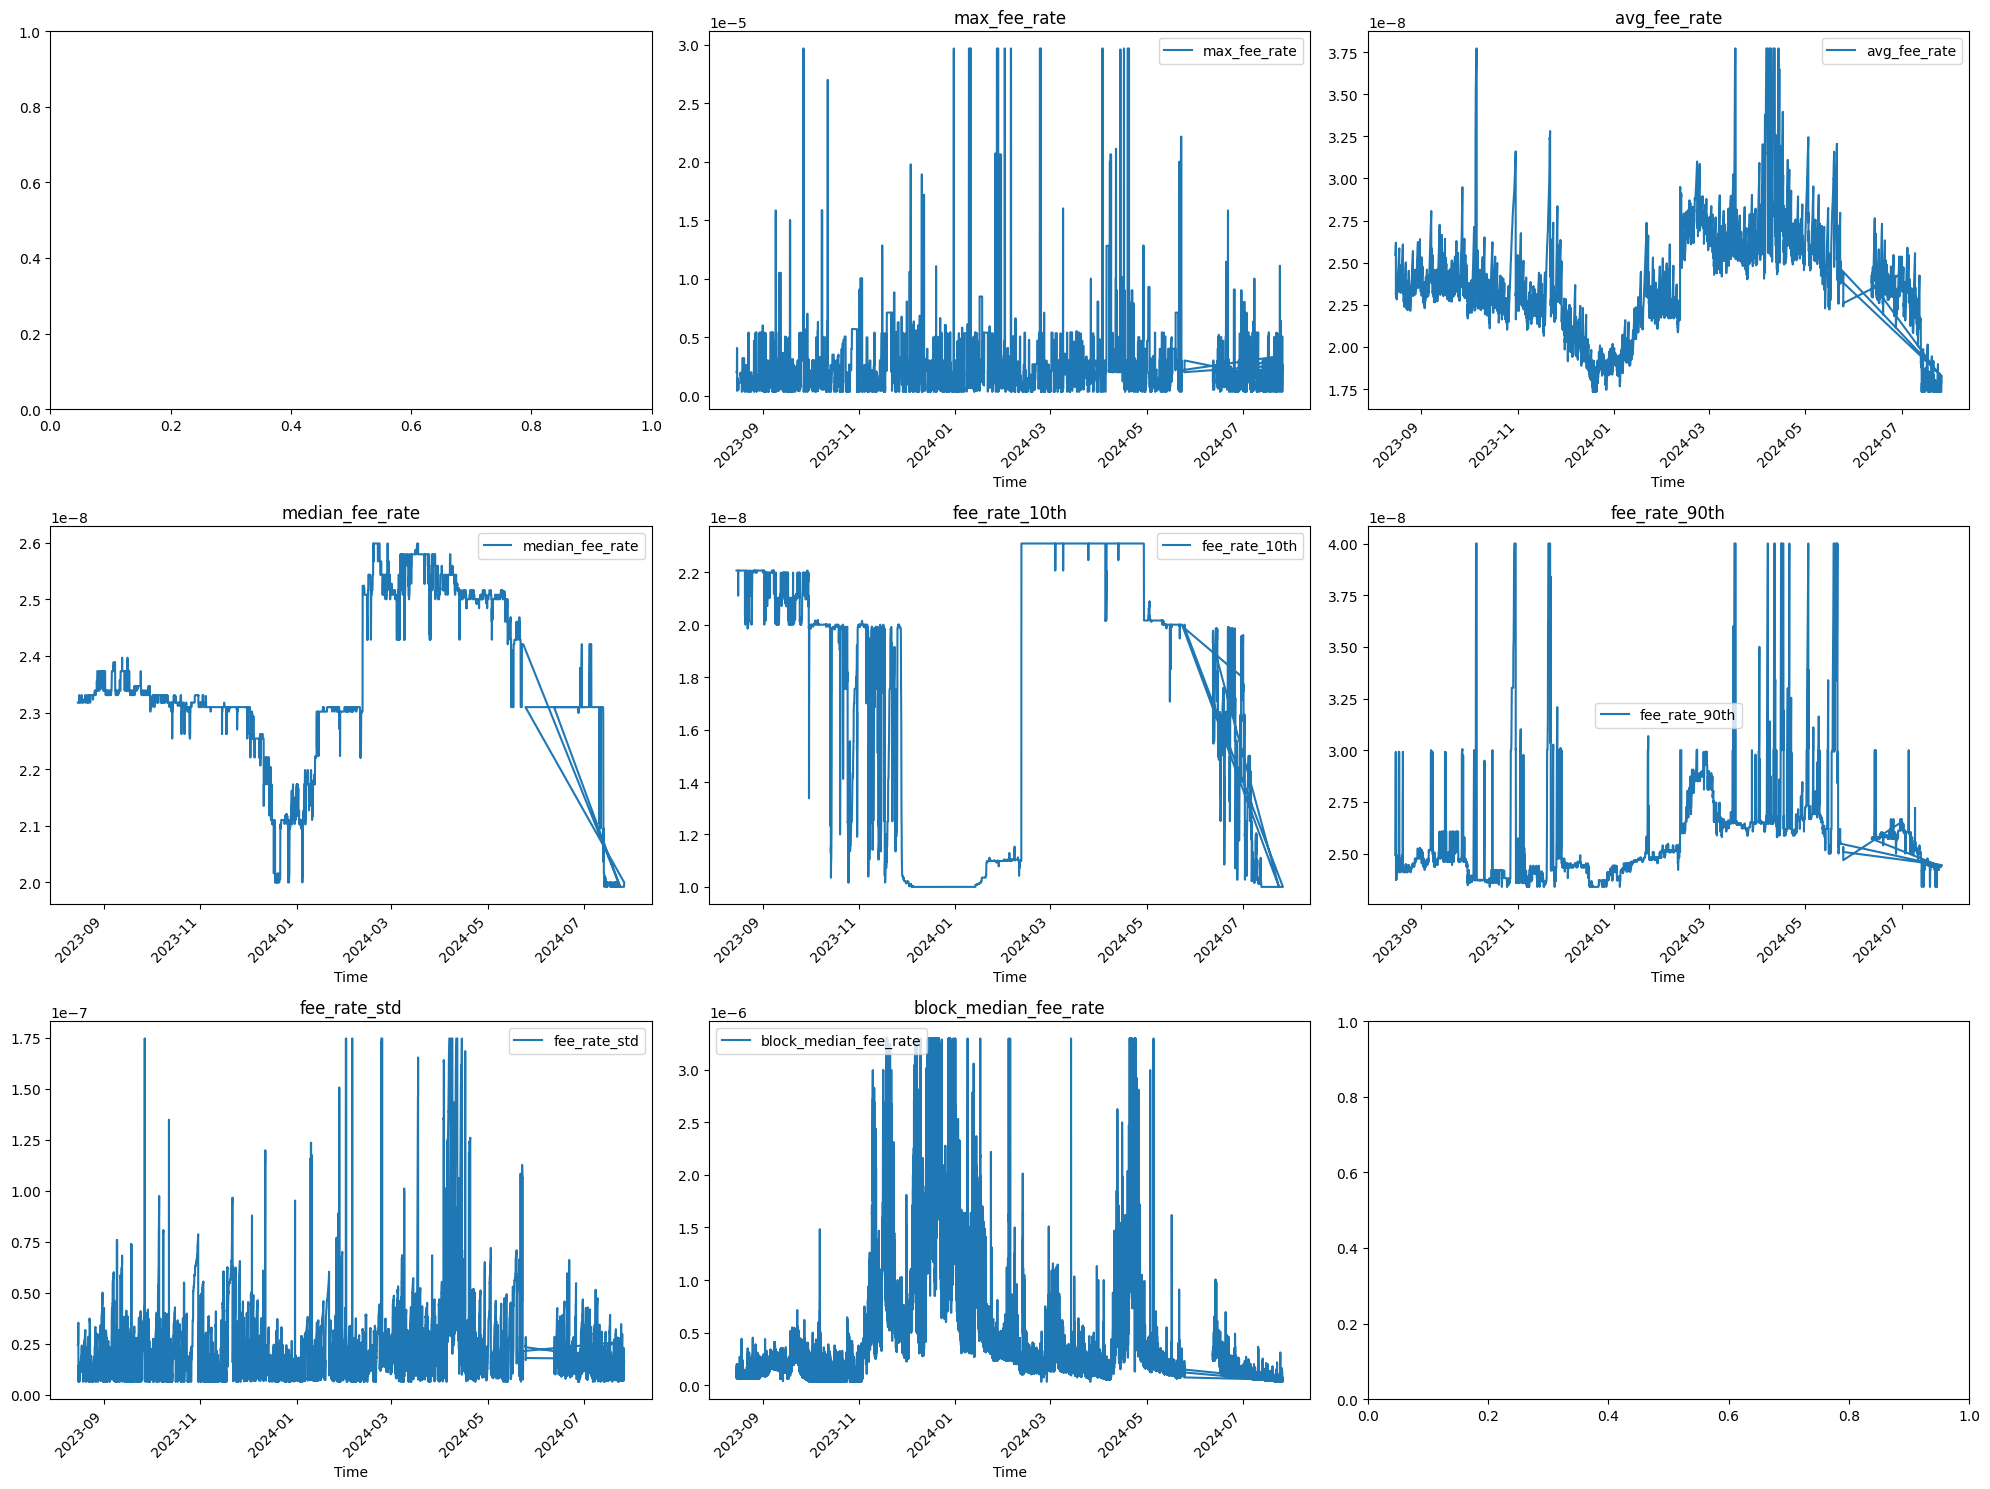

In [108]:

plot_time_series(df_cleaned, fee_features,rows=3, cols=3)



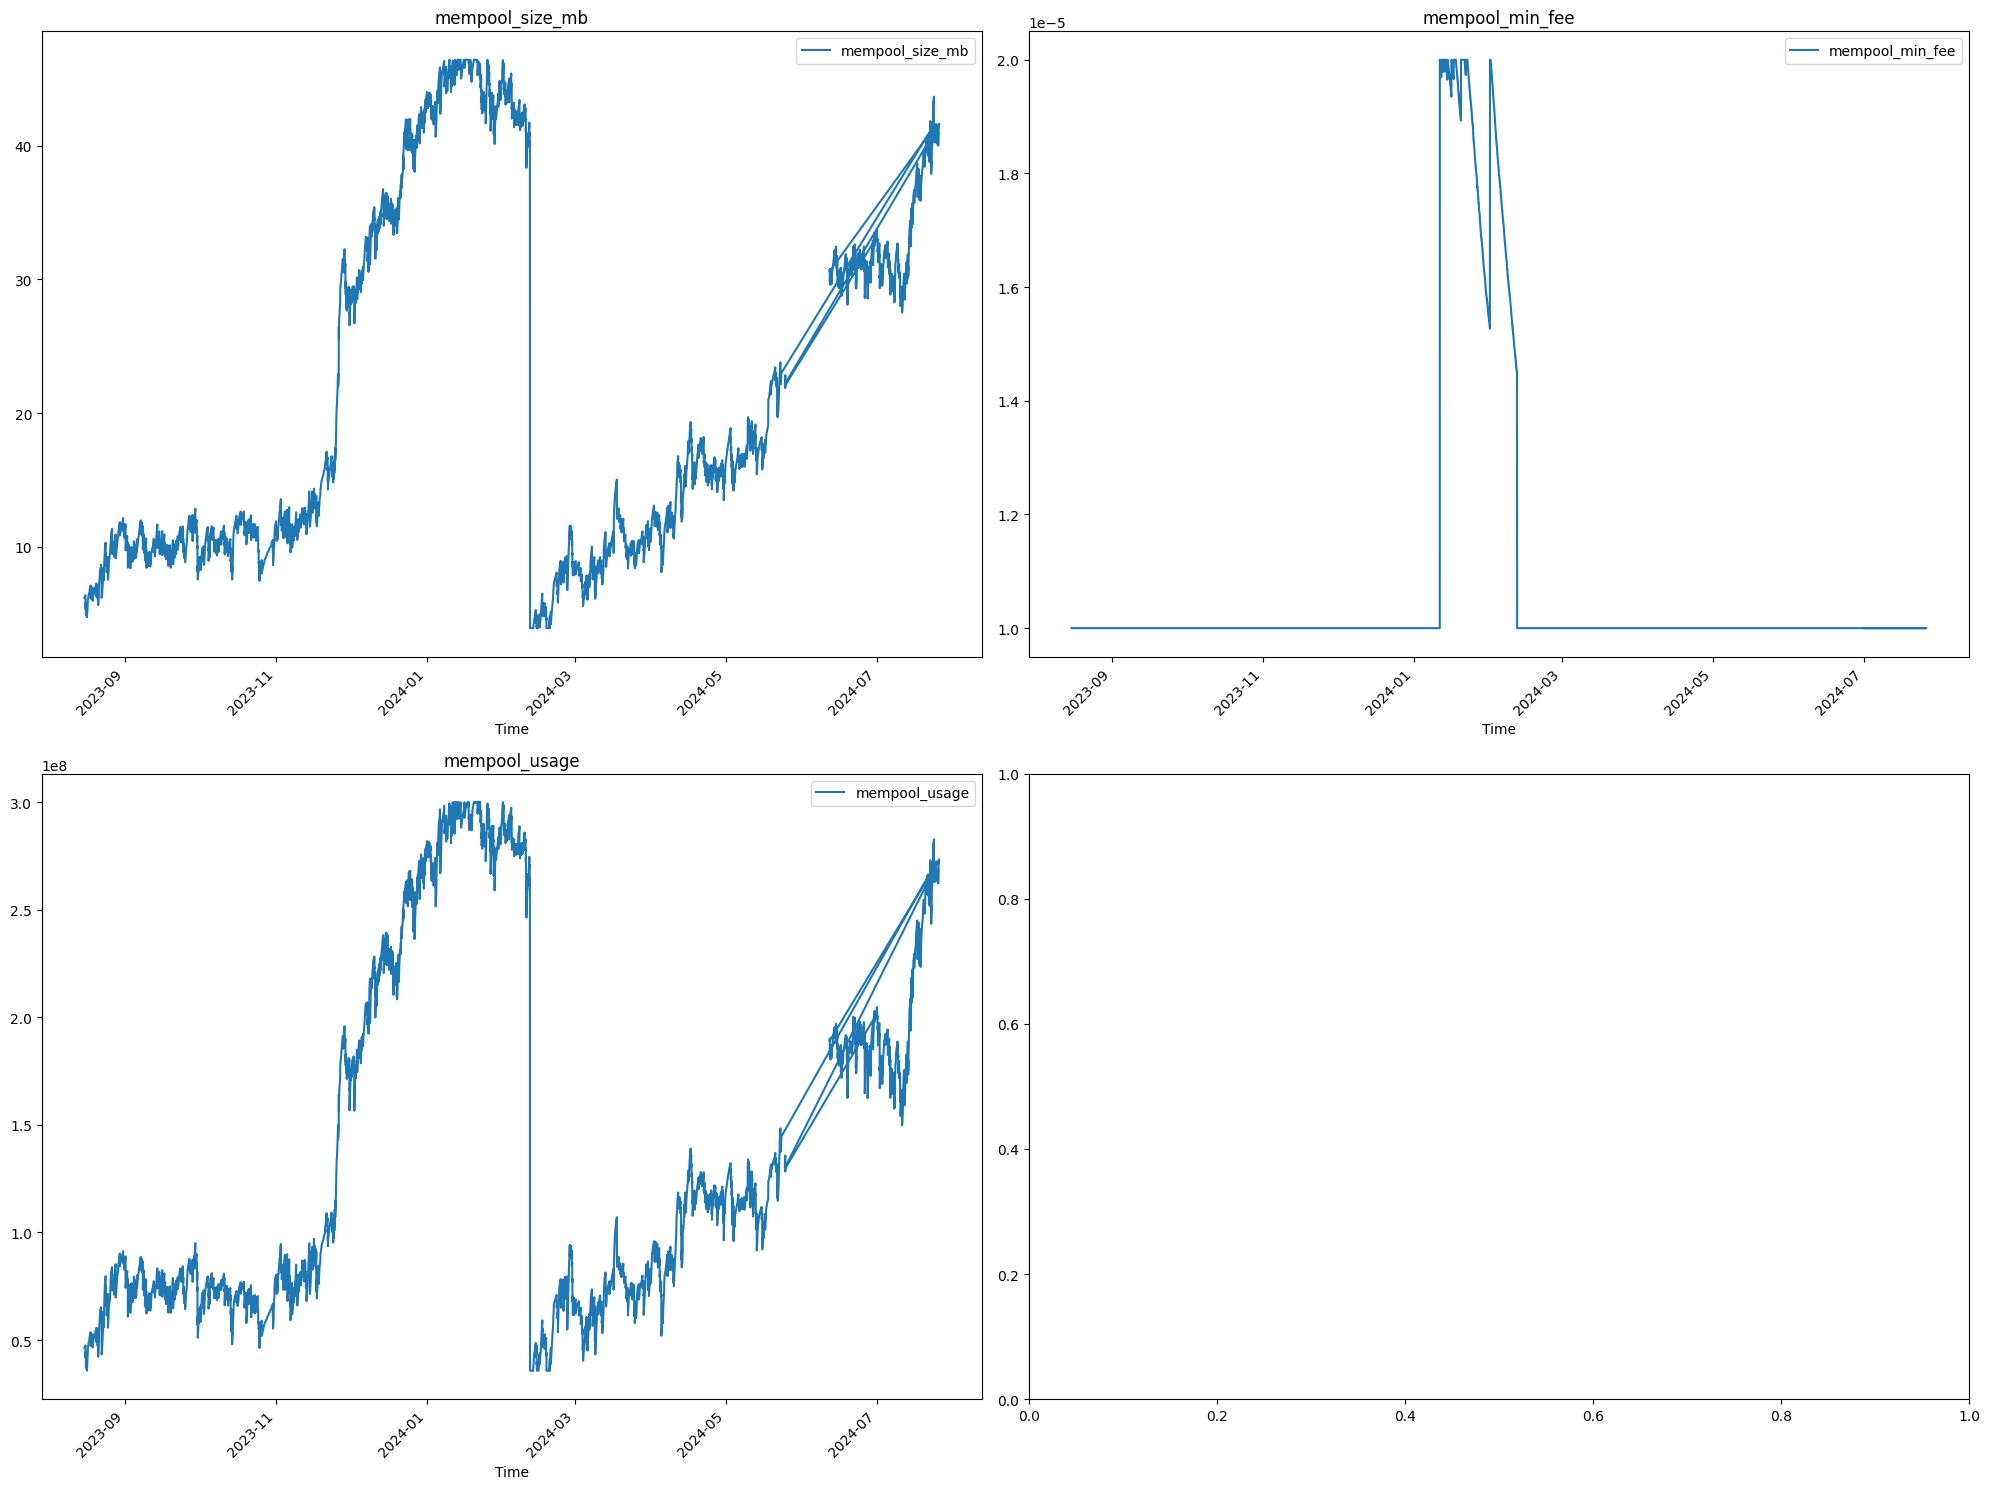

In [109]:
plot_time_series(df_cleaned, mempool_features,rows=2,cols=2)


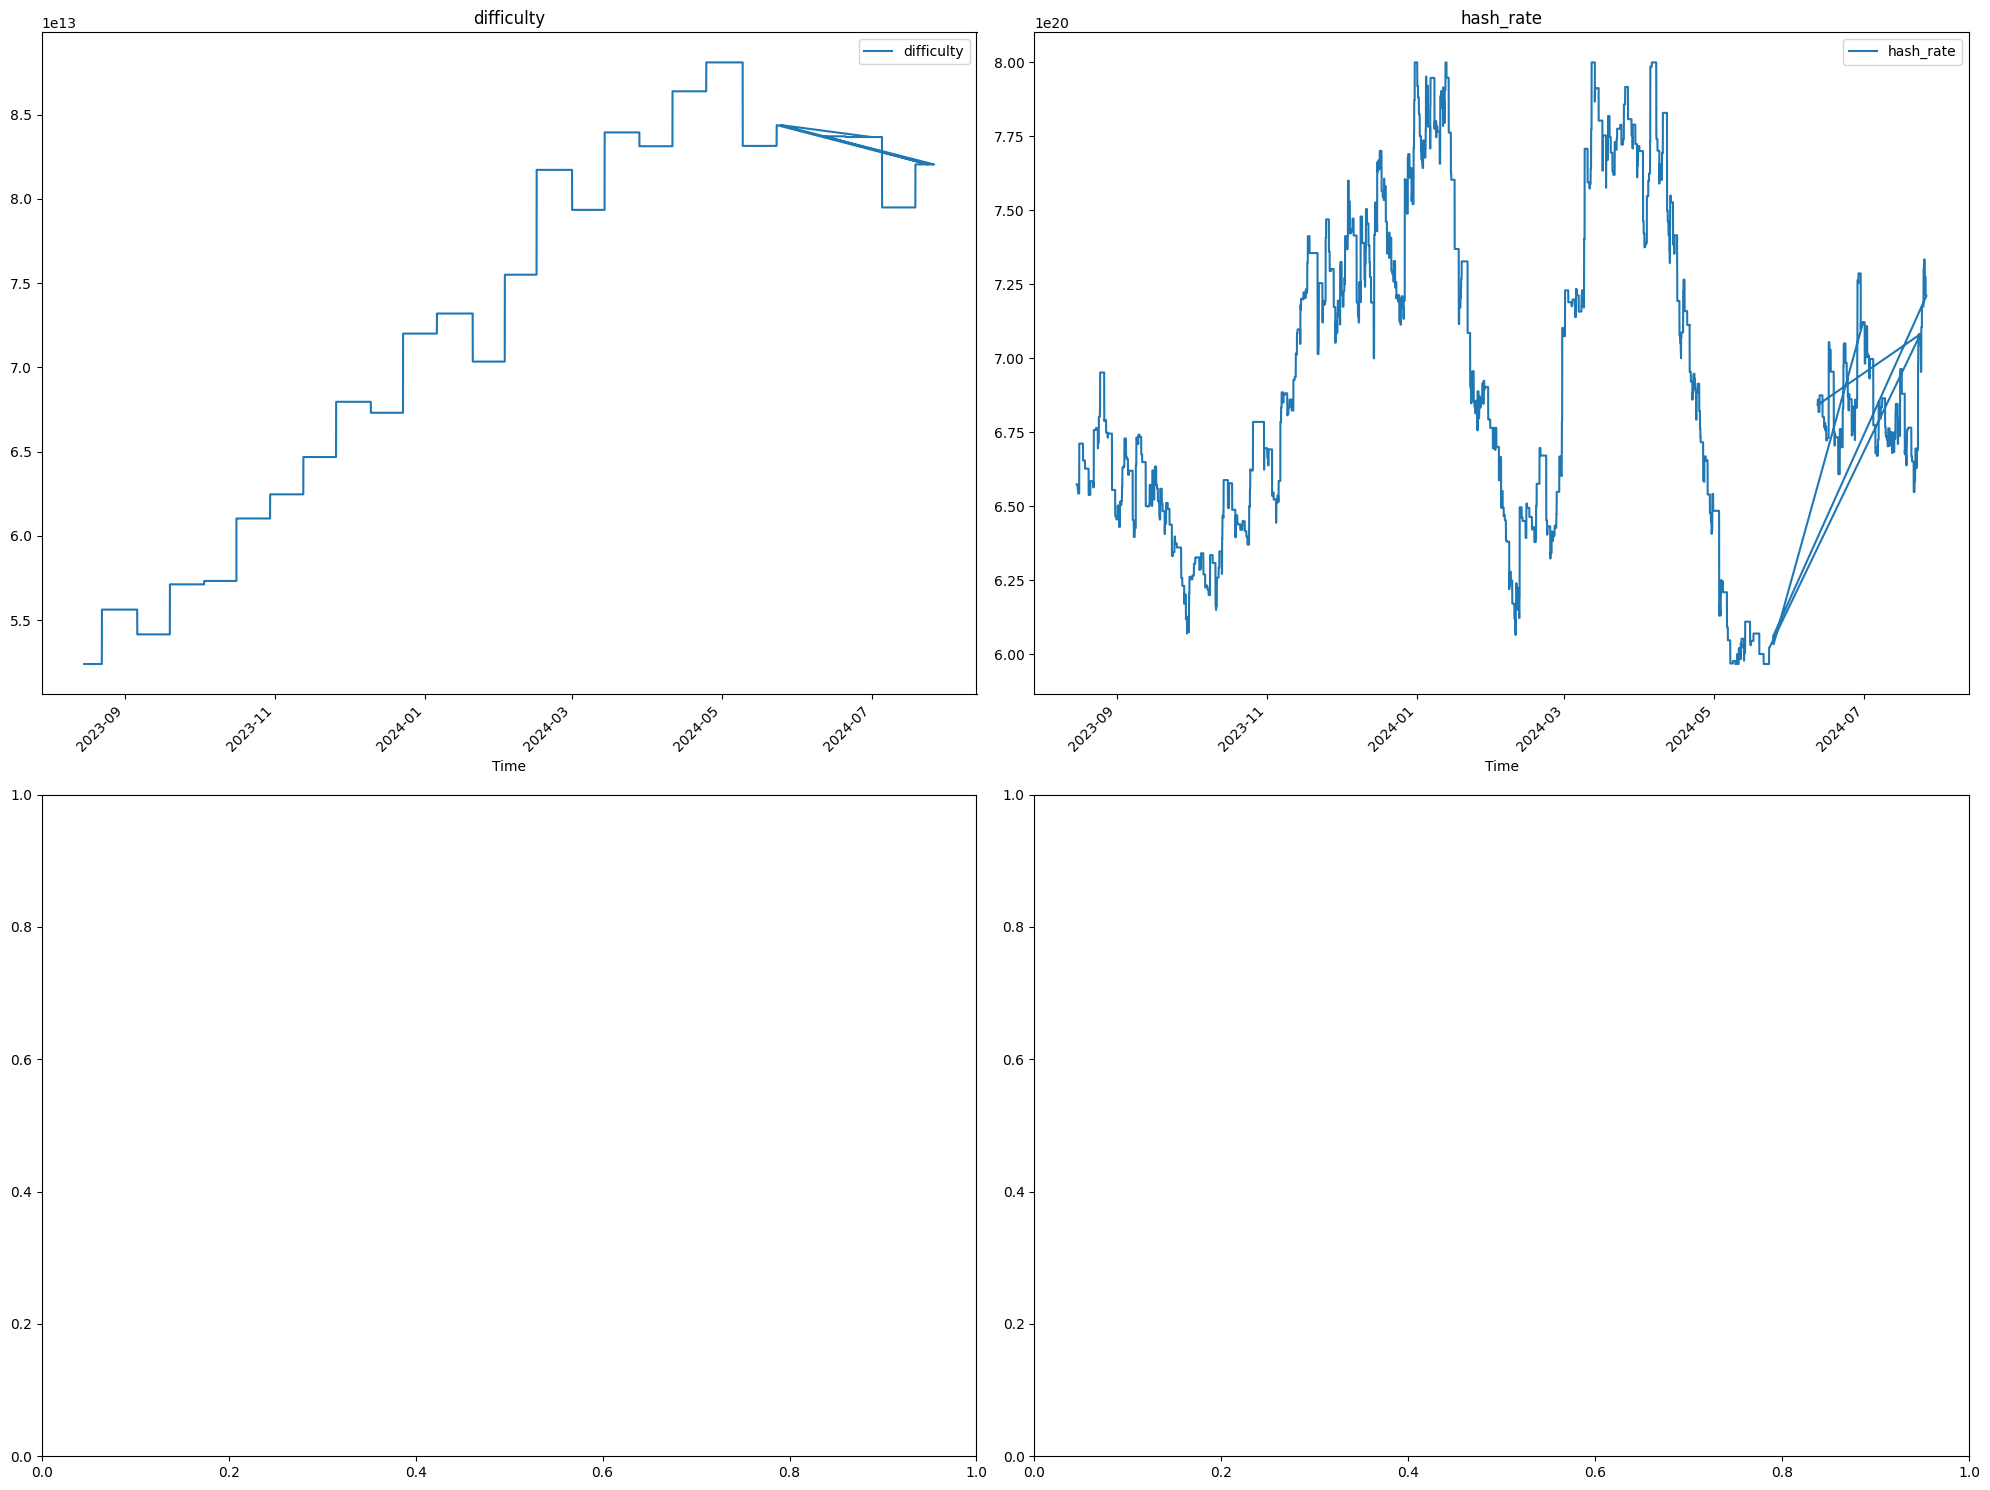

In [110]:
plot_time_series(df_cleaned, network_features,rows=2,cols=2)

Please ignore the empty plots in above visulization plots, they just make the plots look better.

X-axis (Time): Represents the time dimension, likely corresponding to a timestamp( the dataframe's index block_time), showing the progression of events (e.g., block generation) over time. 

Y-axis (Data Values): Represents the values of the features plotting (e.g., block_height, timestamp, block_weight). These are the numerical values of each respective column.

Block Weight (Rightmost Plot):

The some other features, such as block_weight, difficulty, hash rate... plot appears highly irregular and may contain many extreme variations, rapidly oscillating. This indicates that either the data for block_weight has anomalies or extreme variability that needs further investigation.


In [111]:
# Calculate the time difference between consecutive blocks
df_cleaned['block_time_diff'] = df_cleaned.index.to_series().diff()

# Set a threshold for what constitutes a large gap (e.g., 15 minutes)
large_gaps = df_cleaned[df_cleaned['block_time_diff'] > pd.Timedelta(minutes=15)]

print(f"Found {len(large_gaps)} gaps larger than 15 minutes:")
print(large_gaps[['block_time_diff']])
# Sort by the largest gaps
large_gaps_sorted = large_gaps.sort_values(by='block_time_diff', ascending=False)
print(large_gaps_sorted.head(10))  # Display the top 10 largest gaps


Found 10338 gaps larger than 15 minutes:
                    block_time_diff
block_time                         
2023-08-15 14:41:37 0 days 00:25:27
2023-08-15 15:31:00 0 days 00:41:41
2023-08-15 16:07:22 0 days 00:36:22
2023-08-15 16:25:26 0 days 00:18:04
2023-08-15 17:44:58 0 days 00:19:55
...                             ...
2024-06-30 08:09:52 0 days 00:56:35
2024-06-30 09:37:46 0 days 00:28:23
2024-06-30 10:14:56 0 days 00:27:22
2024-06-30 10:46:10 0 days 00:22:57
2024-06-30 11:25:16 0 days 00:33:00

[10338 rows x 1 columns]
                      timestamp  block_height  tx_count  mempool_size_mb  \
block_time                                                                 
2024-07-23 18:30:01  1725724360        853600  119400.0        41.435642   
2024-06-30 11:40:42  1725684848        850100   71802.0        33.003580   
2024-01-07 07:53:38  1725346228        824718  128123.0        45.568491   
2023-12-02 14:44:29  1725283705        819429   77088.0        29.124117   
2023-12-0

Investigate the Gaps:

The large gaps (e.g., 61 days, 36 days) could indicate missing data or recording issues. 

Analyze Block Intervals:

The block_interval represents the time between consecutive blocks, and values like 7303.0 and 6109.0 indicate unusually long intervals. These should be investigated to see if they correspond to periods of low activity or if there’s a different reason (such as an error in block generation).

Dataset Investigation - bitcoin_data_history2.csv

After investigating the bitcoin_data_history2.csv dataset, I found that several columns, including block_height, are not sorted chronologically. For instance, the block_height column exhibits irregular jumps, such as from 844730 to 853600, and from 853597 to 847530, indicating that the blocks are out of order. To ensure consistency, I will sort the block_height column in ascending order, which will organize the blocks from smallest to largest, aligning them correctly in time.

In [112]:
# Sort the dataset by the 'block_height' column in ascending order
df_cleaned = df_cleaned.sort_values(by='block_height', ascending=True)

print(df_cleaned.head())




                      timestamp  block_height  tx_count  mempool_size_mb  \
block_time                                                                 
2023-08-15 13:04:26  1725156820        803299   29424.0         6.170293   
2023-08-15 13:07:55  1725156825        803300   29433.0         6.172034   
2023-08-15 13:08:04  1725156830        803301   29441.0         6.173171   
2023-08-15 13:16:21  1725156834        803302   29452.0         6.174935   
2023-08-15 13:26:12  1725156839        803303   29460.0         6.176499   

                     max_fee_rate  avg_fee_rate  median_fee_rate  \
block_time                                                         
2023-08-15 13:04:26      0.000002  2.546653e-08     2.317460e-08   
2023-08-15 13:07:55      0.000002  2.547332e-08     2.317460e-08   
2023-08-15 13:08:04      0.000002  2.547714e-08     2.317460e-08   
2023-08-15 13:16:21      0.000002  2.548790e-08     2.317460e-08   
2023-08-15 13:26:12      0.000002  2.550336e-08     2.31746

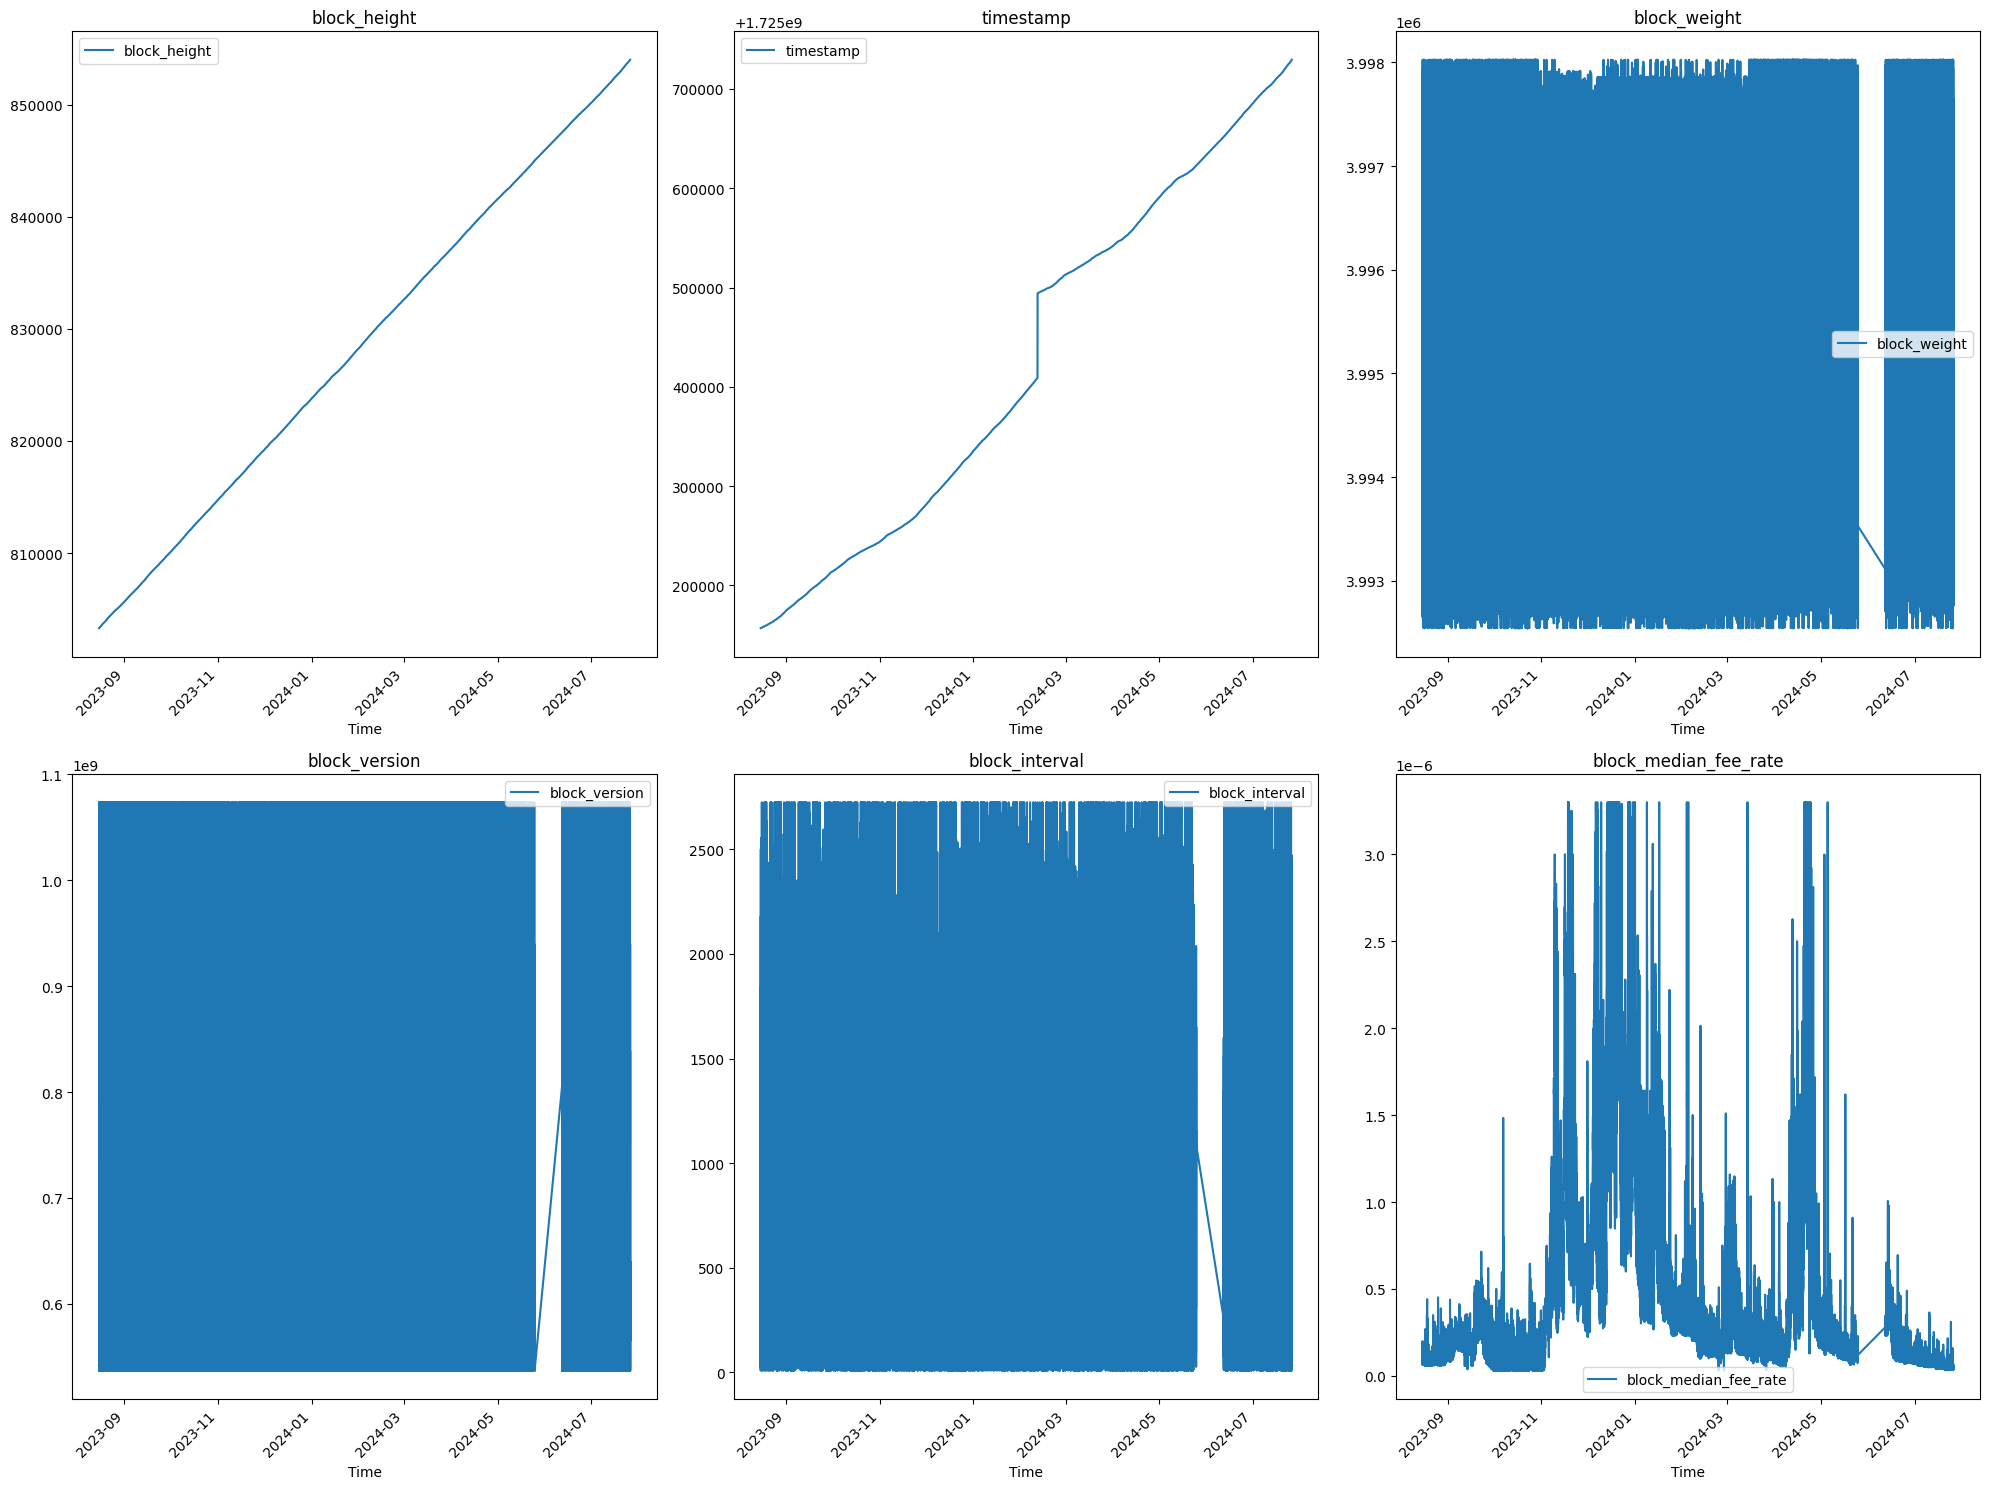

In [113]:
plot_time_series(df_cleaned, block_features,rows=2, cols=3)

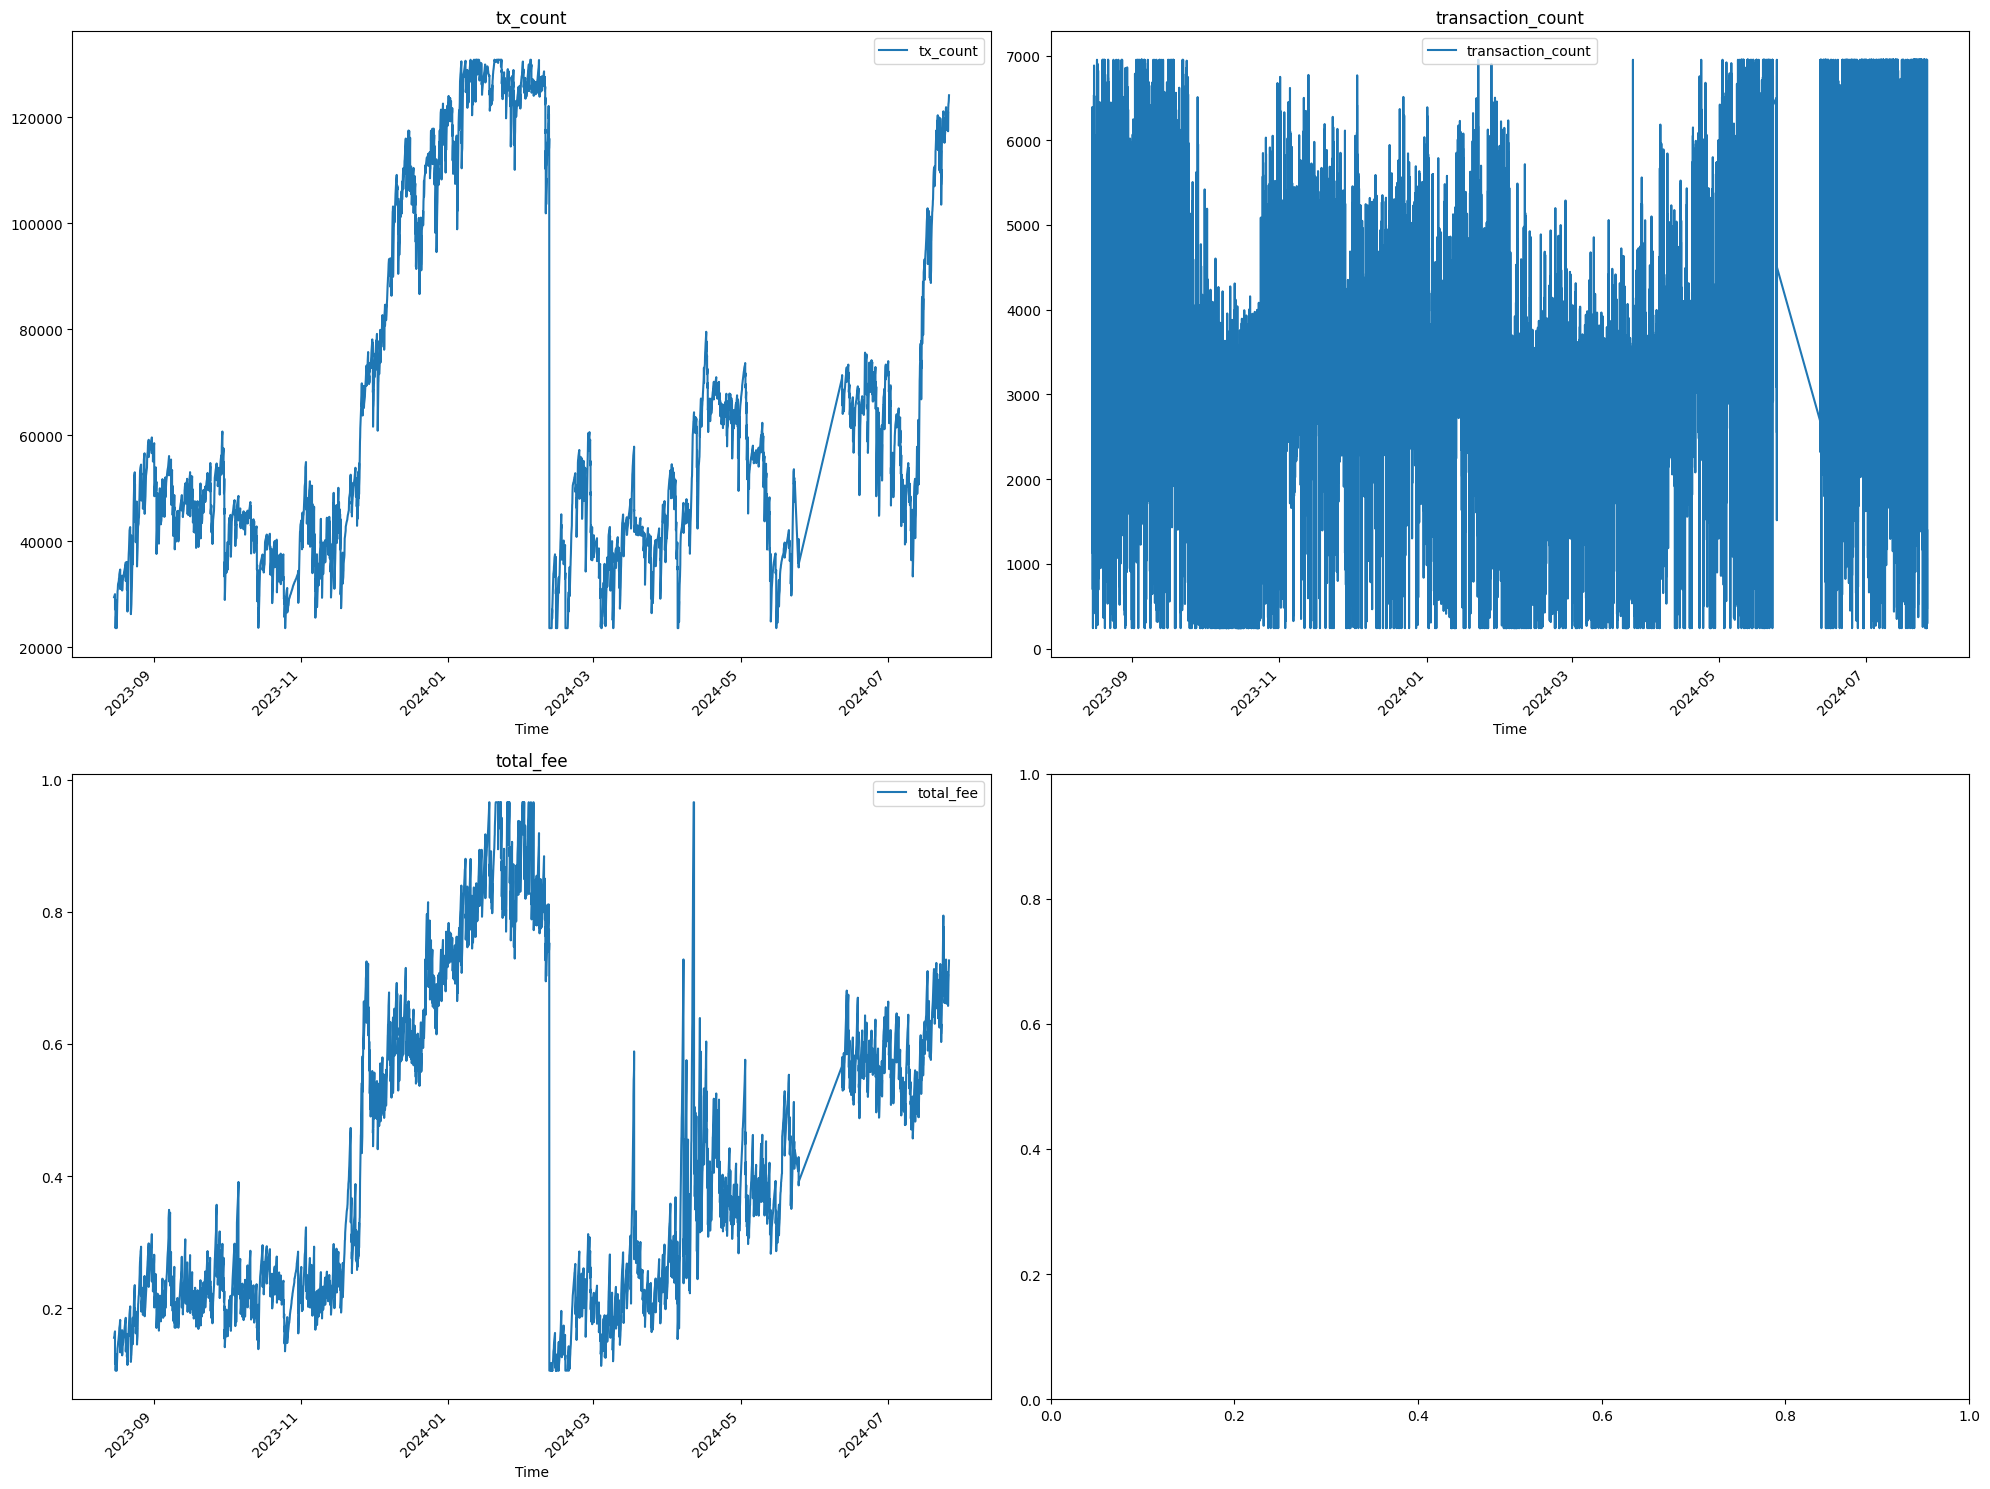

In [114]:
plot_time_series(df_cleaned, transaction_features,rows=2, cols=2)

Above plots shows the dataset still exist missing values, to investage the reason, doing following:

In [115]:
# Calculate the time difference between consecutive blocks
df_cleaned['block_time_diff'] = df_cleaned.index.to_series().diff()

# Set a threshold for what constitutes a large gap (e.g., 15 minutes)
large_gaps = df_cleaned[df_cleaned['block_time_diff'] > pd.Timedelta(minutes=15)]

print(f"Found {len(large_gaps)} gaps larger than 15 minutes:")
print(large_gaps[['block_time_diff']])
# Sort by the largest gaps
large_gaps_sorted = large_gaps.sort_values(by='block_time_diff', ascending=False)
print(large_gaps_sorted.head(10))  # Display the top 10 largest gaps

Found 10340 gaps larger than 15 minutes:
                    block_time_diff
block_time                         
2023-08-15 14:41:37 0 days 00:25:27
2023-08-15 15:31:00 0 days 00:41:41
2023-08-15 16:07:22 0 days 00:36:22
2023-08-15 16:25:26 0 days 00:18:04
2023-08-15 17:44:58 0 days 00:19:55
...                             ...
2024-07-26 02:40:19 0 days 00:41:11
2024-07-26 03:25:54 0 days 00:16:46
2024-07-26 04:05:45 0 days 00:15:26
2024-07-26 04:54:25 0 days 00:20:49
2024-07-26 06:19:37 0 days 00:35:04

[10340 rows x 1 columns]
                      timestamp  block_height  tx_count  mempool_size_mb  \
block_time                                                                 
2024-06-11 22:34:31  1725651661        847530   70581.0        30.580466   
2024-05-24 20:22:57  1725622584        844972   35923.0        22.151825   
2024-01-07 07:53:38  1725346228        824718  128123.0        45.568491   
2023-12-02 14:44:29  1725283705        819429   77088.0        29.124117   
2023-12-0

In [116]:
df_cleaned.to_csv('clean.csv')

In [117]:
df_cleaned=pd.read_csv('clean.csv',index_col=0)
df_cleaned

,timestamp,block_height,tx_count,mempool_size_mb,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,fee_rate_std,...,hash_rate,mempool_min_fee,total_fee,mempool_usage,transaction_count,block_weight,block_version,block_interval,block_median_fee_rate,block_time_diff
block_time,,,,,,,,,,,,,,,,,,,,,
2023-08-15 13:04:26,1725156820,803299,29424.0,6.170293,0.000002,2.546653e-08,2.317460e-08,2.206349e-08,2.492063e-08,2.449531e-08,...,6.574572e+20,0.00001,0.155298,46511376.0,3401.0,3993402,793116672,410.0,8.000000e-08,NaN
2023-08-15 13:07:55,1725156825,803300,29433.0,6.172034,0.000002,2.547332e-08,2.317460e-08,2.206349e-08,2.492754e-08,2.449685e-08,...,6.574572e+20,0.00001,0.155378,46523920.0,5048.0,3993409,557588480,209.0,6.397059e-08,0 days 00:03:29
2023-08-15 13:08:04,1725156830,803301,29441.0,6.173171,0.000002,2.547714e-08,2.317460e-08,2.206349e-08,2.500000e-08,2.449535e-08,...,6.574572e+20,0.00001,0.155421,46534048.0,6392.0,3997929,536870912,9.0,6.345588e-08,0 days 00:00:09
2023-08-15 13:16:21,1725156834,803302,29452.0,6.174935,0.000002,2.548790e-08,2.317460e-08,2.206349e-08,2.500000e-08,2.451369e-08,...,6.574572e+20,0.00001,0.155512,46548576.0,4308.0,3993126,783720448,497.0,6.389706e-08,0 days 00:08:17
2023-08-15 13:26:12,1725156839,803303,29460.0,6.176499,0.000002,2.550336e-08,2.317460e-08,2.206349e-08,2.500000e-08,2.456636e-08,...,6.574572e+20,0.00001,0.155637,46560192.0,3335.0,3993490,830971904,591.0,7.059715e-08,0 days 00:09:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26 07:04:28,1725729403,853993,124021.0,41.626355,0.000003,1.824585e-08,2.000000e-08,1.000000e-08,2.444444e-08,1.656256e-08,...,7.212194e+20,0.00001,0.724587,273253392.0,1116.0,3993023,536928260,191.0,4.984127e-08,0 days 00:03:11
2024-07-26 07:04:38,1725729414,853994,124046.0,41.631274,0.000003,1.825457e-08,2.000000e-08,1.000000e-08,2.444444e-08,1.658836e-08,...,7.212194e+20,0.00001,0.724871,273289040.0,296.0,3993236,583196672,10.0,4.000000e-08,0 days 00:00:10
2024-07-26 07:09:43,1725729426,853995,124072.0,41.638839,0.000003,1.826209e-08,2.000000e-08,1.000000e-08,2.444444e-08,1.660559e-08,...,7.212194e+20,0.00001,0.725211,273330864.0,2766.0,3992892,848871424,305.0,4.034129e-08,0 days 00:05:05


After observed the cleaned dataset clean.csv, I find that this dataset miss the values from block_height 845001 to 847530. So I plan to collect these missing data again. And these missing data saved in bitcoin_data_history3.csv. Next, after observeed  bitcoin_data_history3.csv, the values from block_height 845001 to 845009 has problem, so collect them again, and stored in bitcoin_data_history4.csv. and merge them with df_cleaned.


In [118]:
df3=pd.read_csv('bitcoin_data_history3.csv')
df3

,timestamp,block_height,tx_count,mempool_size_mb,min_fee_rate,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,...,difficulty,hash_rate,mempool_min_fee,total_fee,mempool_usage,transaction_count,block_weight,block_version,block_interval,block_median_fee_rate
0,1726367959,845001,29644,8.003222,1.000000e-08,0.000003,2.796975e-08,2.142857e-08,2.119048e-08,4.000000e-08,...,8.438146e+13,5.662446e+20,0.00001,0.218049,54597552,4499,3993530,536879104,NaN,1.200000e-07
1,1726367965,845002,29653,8.006439,1.000000e-08,0.000003,2.798079e-08,2.142857e-08,2.119048e-08,4.000000e-08,...,8.438146e+13,5.662446e+20,0.00001,0.218265,54616048,5187,3992942,602767360,397.0,9.891347e-08
2,1726367970,845003,29659,8.007212,1.000000e-08,0.000003,2.798786e-08,2.142857e-08,2.119048e-08,4.000000e-08,...,8.438146e+13,5.662446e+20,0.00001,0.218314,54623328,7508,3993760,602054656,42.0,8.201550e-08
3,1726367976,845004,29666,8.008900,1.000000e-08,0.000003,2.800992e-08,2.142857e-08,2.119048e-08,4.000000e-08,...,8.438146e+13,5.662446e+20,0.00001,0.218585,54632848,2224,3993096,594386944,63.0,8.500000e-08
4,1726367981,845005,29679,8.011177,1.000000e-08,0.000003,2.802561e-08,2.142857e-08,2.119048e-08,4.000000e-08,...,8.438146e+13,5.662446e+20,0.00001,0.218727,54650880,4273,3993506,541065216,707.0,1.000000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,1726379030,847526,14046,7.132392,1.000000e-08,0.000002,2.124814e-08,2.119048e-08,1.454545e-08,2.150794e-08,...,8.371665e+13,5.771581e+20,0.00001,0.131633,43006816,3749,3993721,680083456,8.0,3.121986e-07
2526,1726379034,847527,14069,7.135339,1.000000e-08,0.000002,2.125066e-08,2.119048e-08,1.462131e-08,2.150794e-08,...,8.371665e+13,5.771581e+20,0.00001,0.131701,43035360,3809,3993417,1073676288,510.0,3.100000e-07
2527,1726379039,847528,14152,7.146816,1.000000e-08,0.000002,2.128105e-08,2.119048e-08,1.497238e-08,2.150794e-08,...,8.371665e+13,5.771581e+20,0.00001,0.132033,43139920,3670,3998043,939524096,1745.0,3.700000e-07
2528,1726379043,847529,14195,7.155815,1.000000e-08,0.000002,2.131367e-08,2.119048e-08,1.504778e-08,2.150794e-08,...,8.371665e+13,5.771581e+20,0.00001,0.132329,43196928,3439,3992883,603447296,647.0,3.480142e-07


In [119]:
# Convert 'block_time' to datetime
df3['block_time'] = pd.to_datetime(df3['block_time'], unit='s')

# Set 'block_time' as index
df3.set_index('block_time', inplace=True)

In [120]:
df_cleaned =df_cleaned.drop(columns=['block_time_diff'])
df3 = df3.drop(columns=[ 'min_fee_rate'])

In [121]:
sf=pd.concat([df_cleaned, df3], axis=0)
sf


,timestamp,block_height,tx_count,mempool_size_mb,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,fee_rate_std,difficulty,hash_rate,mempool_min_fee,total_fee,mempool_usage,transaction_count,block_weight,block_version,block_interval,block_median_fee_rate
block_time,,,,,,,,,,,,,,,,,,,,
2023-08-15 13:04:26,1725156820,803299,29424.0,6.170293,0.000002,2.546653e-08,2.317460e-08,2.206349e-08,2.492063e-08,2.449531e-08,5.239118e+13,6.574572e+20,0.00001,0.155298,46511376.0,3401.0,3993402,793116672,410.0,8.000000e-08
2023-08-15 13:07:55,1725156825,803300,29433.0,6.172034,0.000002,2.547332e-08,2.317460e-08,2.206349e-08,2.492754e-08,2.449685e-08,5.239118e+13,6.574572e+20,0.00001,0.155378,46523920.0,5048.0,3993409,557588480,209.0,6.397059e-08
2023-08-15 13:08:04,1725156830,803301,29441.0,6.173171,0.000002,2.547714e-08,2.317460e-08,2.206349e-08,2.500000e-08,2.449535e-08,5.239118e+13,6.574572e+20,0.00001,0.155421,46534048.0,6392.0,3997929,536870912,9.0,6.345588e-08
2023-08-15 13:16:21,1725156834,803302,29452.0,6.174935,0.000002,2.548790e-08,2.317460e-08,2.206349e-08,2.500000e-08,2.451369e-08,5.239118e+13,6.574572e+20,0.00001,0.155512,46548576.0,4308.0,3993126,783720448,497.0,6.389706e-08
2023-08-15 13:26:12,1725156839,803303,29460.0,6.176499,0.000002,2.550336e-08,2.317460e-08,2.206349e-08,2.500000e-08,2.456636e-08,5.239118e+13,6.574572e+20,0.00001,0.155637,46560192.0,3335.0,3993490,830971904,591.0,7.059715e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-11 21:41:52,1726379030,847526,14046.0,7.132392,0.000002,2.124814e-08,2.119048e-08,1.454545e-08,2.150794e-08,2.728880e-08,8.371665e+13,5.771581e+20,0.00001,0.131633,43006816.0,3749.0,3993721,680083456,8.0,3.121986e-07
2024-06-11 21:50:22,1726379034,847527,14069.0,7.135339,0.000002,2.125066e-08,2.119048e-08,1.462131e-08,2.150794e-08,2.726715e-08,8.371665e+13,5.771581e+20,0.00001,0.131701,43035360.0,3809.0,3993417,1073676288,510.0,3.100000e-07
2024-06-11 22:19:27,1726379039,847528,14152.0,7.146816,0.000002,2.128105e-08,2.119048e-08,1.497238e-08,2.150794e-08,2.722281e-08,8.371665e+13,5.771581e+20,0.00001,0.132033,43139920.0,3670.0,3998043,939524096,1745.0,3.700000e-07


In [122]:
sf[sf['block_height'].duplicated(keep=False)]

,timestamp,block_height,tx_count,mempool_size_mb,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,fee_rate_std,difficulty,hash_rate,mempool_min_fee,total_fee,mempool_usage,transaction_count,block_weight,block_version,block_interval,block_median_fee_rate
block_time,,,,,,,,,,,,,,,,,,,,
2024-05-25 01:50:32,1725622840,845001,35713.0,22.084927,0.000003,2.259575e-08,2.309524e-08,1.986111e-08,2.468254e-08,1.793692e-08,8.438146e+13,6.034054e+20,0.00001,0.391588,129777248.0,4499.0,3993530,536879104,1088.0,1.200000e-07
2024-06-11 22:34:31,1725651661,847530,70581.0,30.580466,0.000001,2.382494e-08,2.309524e-08,1.928994e-08,2.571429e-08,1.750237e-08,8.371665e+13,6.842253e+20,0.00001,0.565794,188935024.0,2688.0,3993113,805298176,257.0,2.800000e-07
2024-05-25 01:50:32,1726367959,845001,29644.0,8.003222,0.000003,2.796975e-08,2.142857e-08,2.119048e-08,4.000000e-08,3.831448e-08,8.438146e+13,5.662446e+20,0.00001,0.218049,54597552.0,4499.0,3993530,536879104,NaN,1.200000e-07
2024-06-11 22:34:31,1726379047,847530,14238.0,7.161379,0.000002,2.133858e-08,2.119048e-08,1.518376e-08,2.150794e-08,2.727516e-08,8.371665e+13,5.771581e+20,0.00001,0.132598,43249632.0,2688.0,3993113,805298176,257.0,2.800000e-07


In [123]:
# Remove duplicate block_height values and keep only the first occurrence
sf = sf.drop_duplicates(subset=['block_height'], keep='first')

# Print the shape of the DataFrame after removing duplicates
print(f"Shape of the DataFrame after removing duplicates: {sf.shape}")


Shape of the DataFrame after removing duplicates: (50447, 20)


In [124]:
# Sort the dataset by the 'block_height' column in ascending order
sf = sf.sort_values(by='block_height', ascending=True)


In [125]:
# Remove outliers for all columns except for 'block_height', 'timestamp', and 'difficulty'
for column in sf.columns:
    if column not in ['block_height', 'timestamp', 'difficulty']:  # Exclude these columns
        sf = handle_outliers(sf, column)

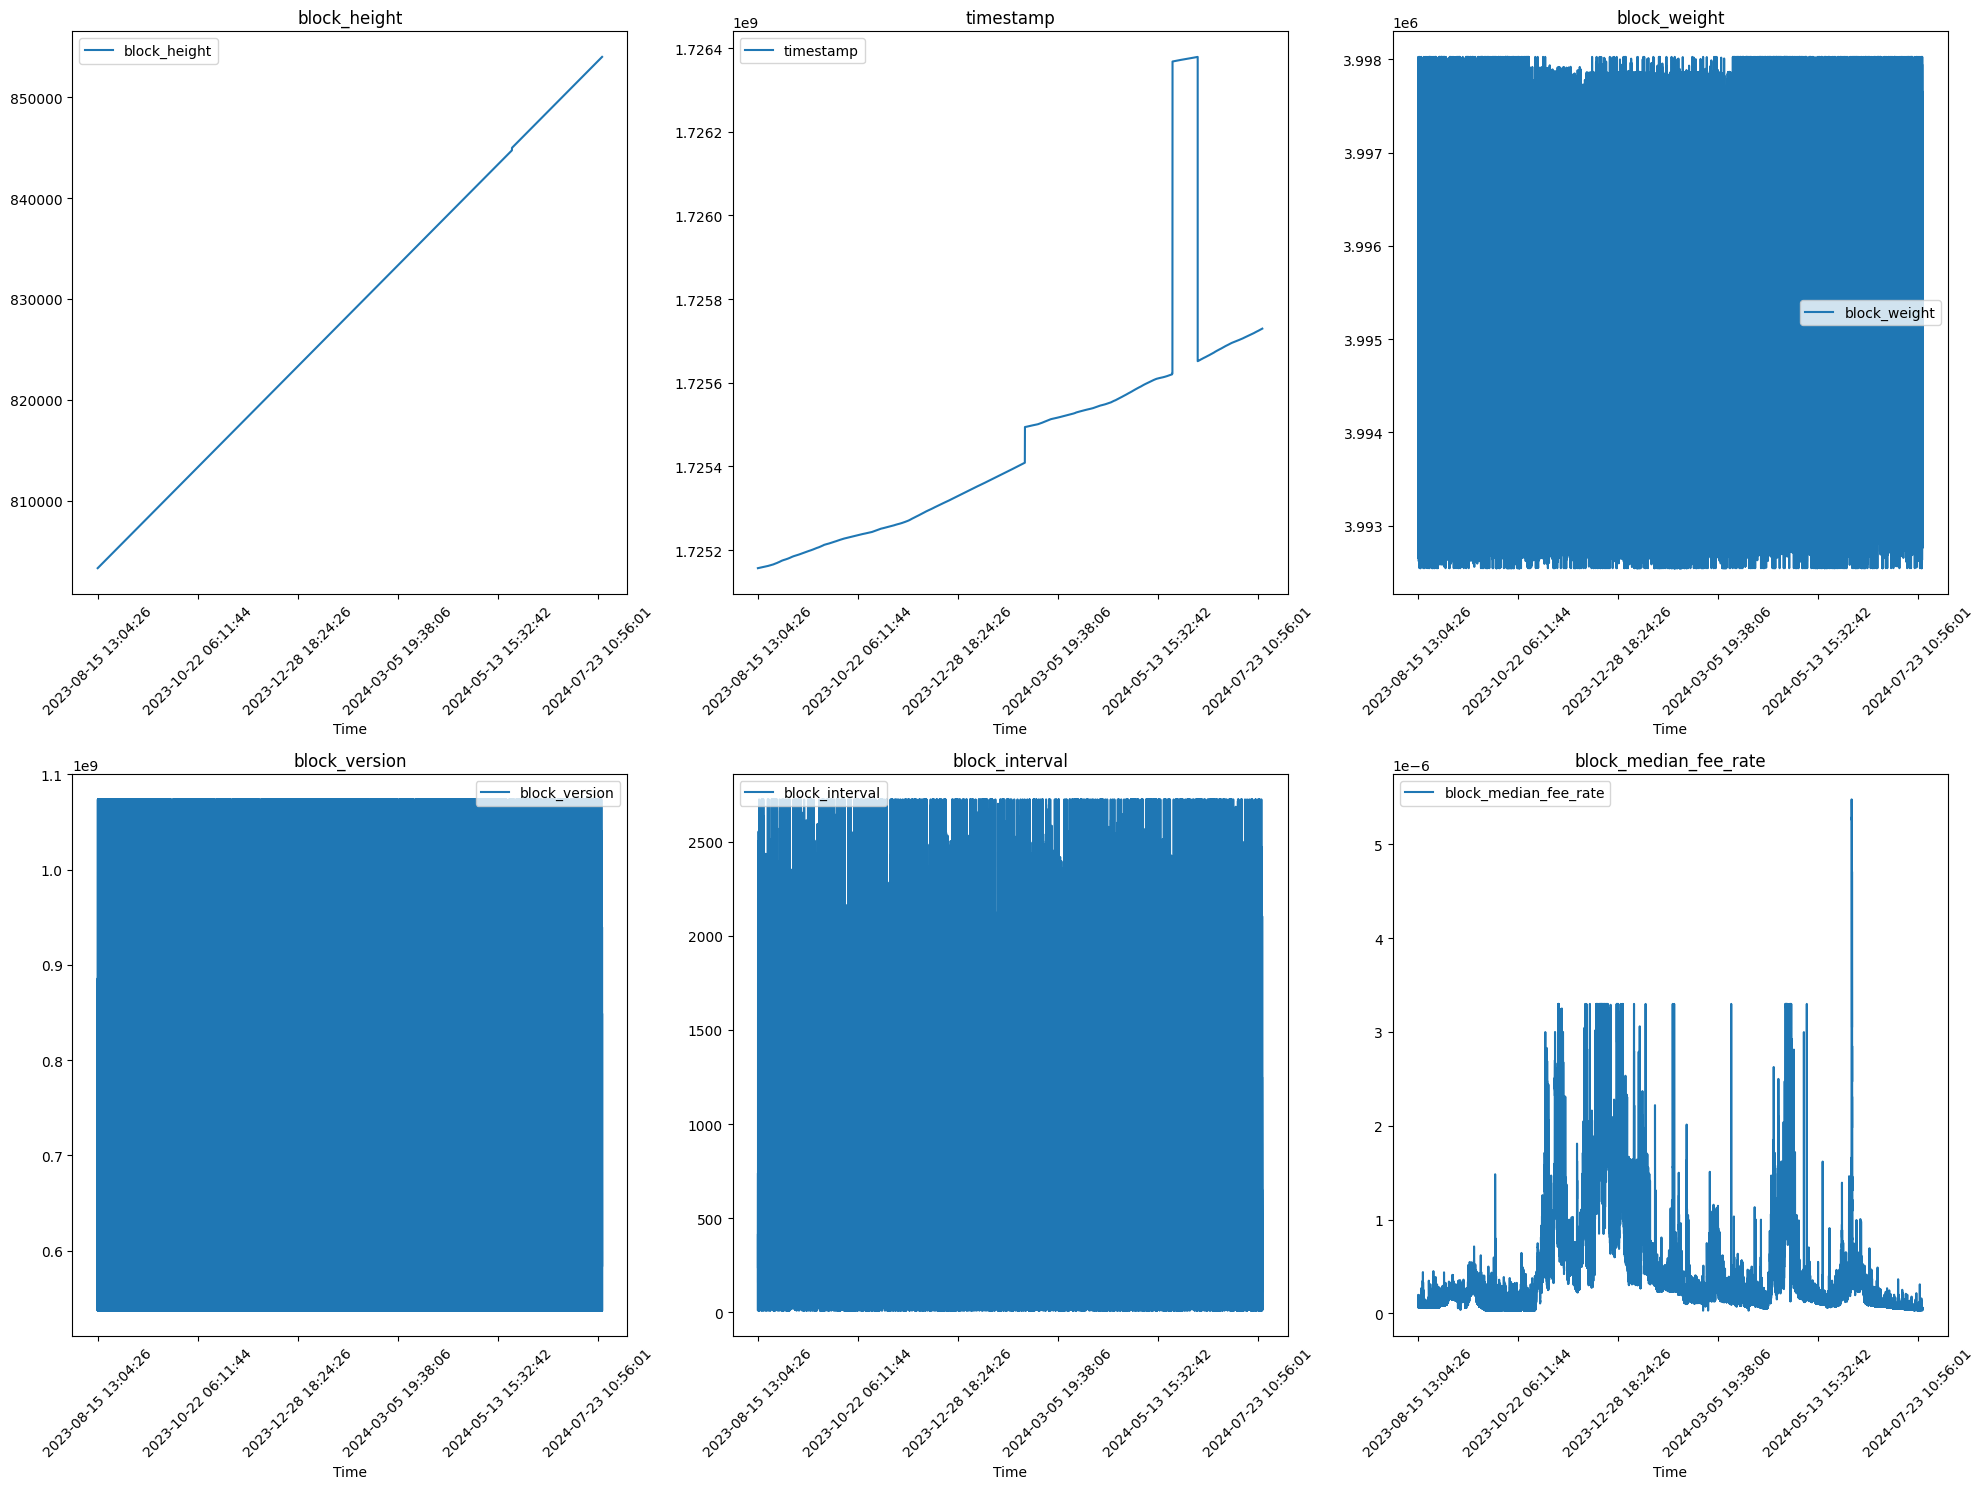

In [126]:
plot_time_series(sf, block_features,rows=2, cols=3)

From the duplicates, I realized that I had mistakenly used real-time mempool information, which is not suitable for our project. The key features we need, such as mempool_size_mb, tx_count, total_fee, mempool_usage, mempool-related fee rates, and hash_rate, represent the state of the mempool in real-time. To use these features effectively for predicting the block_median_fee_rate, we will need to capture this data over time ourselves, as the historical mempool data is not inherently stored by the Bitcoin node.

Next Steps:

I will set up a process to collect real-time data, which will include both mempool and block information. While I am gathering this data over time, I will initially focus on building models using only block data. Once I have collected sufficient real-time mempool data, I will update and refine the models to incorporate the additional features from the mempool.

In [127]:
# Extract the block info columns only
sf=sf[['block_height','difficulty','transaction_count','block_weight','block_version','block_interval','block_median_fee_rate']]
sf

,block_height,difficulty,transaction_count,block_weight,block_version,block_interval,block_median_fee_rate
block_time,,,,,,,
2023-08-15 13:04:26,803299,5.239118e+13,3401.0,3993402,793116672,410.0,8.000000e-08
2023-08-15 13:07:55,803300,5.239118e+13,5048.0,3993409,557588480,209.0,6.397059e-08
2023-08-15 13:08:04,803301,5.239118e+13,6392.0,3997929,536870912,9.0,6.345588e-08
2023-08-15 13:16:21,803302,5.239118e+13,4308.0,3993126,783720448,497.0,6.389706e-08
2023-08-15 13:26:12,803303,5.239118e+13,3335.0,3993490,830971904,591.0,7.059715e-08
...,...,...,...,...,...,...,...
2024-07-26 07:04:28,853993,8.204773e+13,1116.0,3993023,536928260,191.0,4.984127e-08
2024-07-26 07:04:38,853994,8.204773e+13,296.0,3993236,583196672,10.0,4.000000e-08
2024-07-26 07:09:43,853995,8.204773e+13,2766.0,3992892,848871424,305.0,4.034129e-08


In [129]:
sf.to_csv('bitcoin_block.csv')

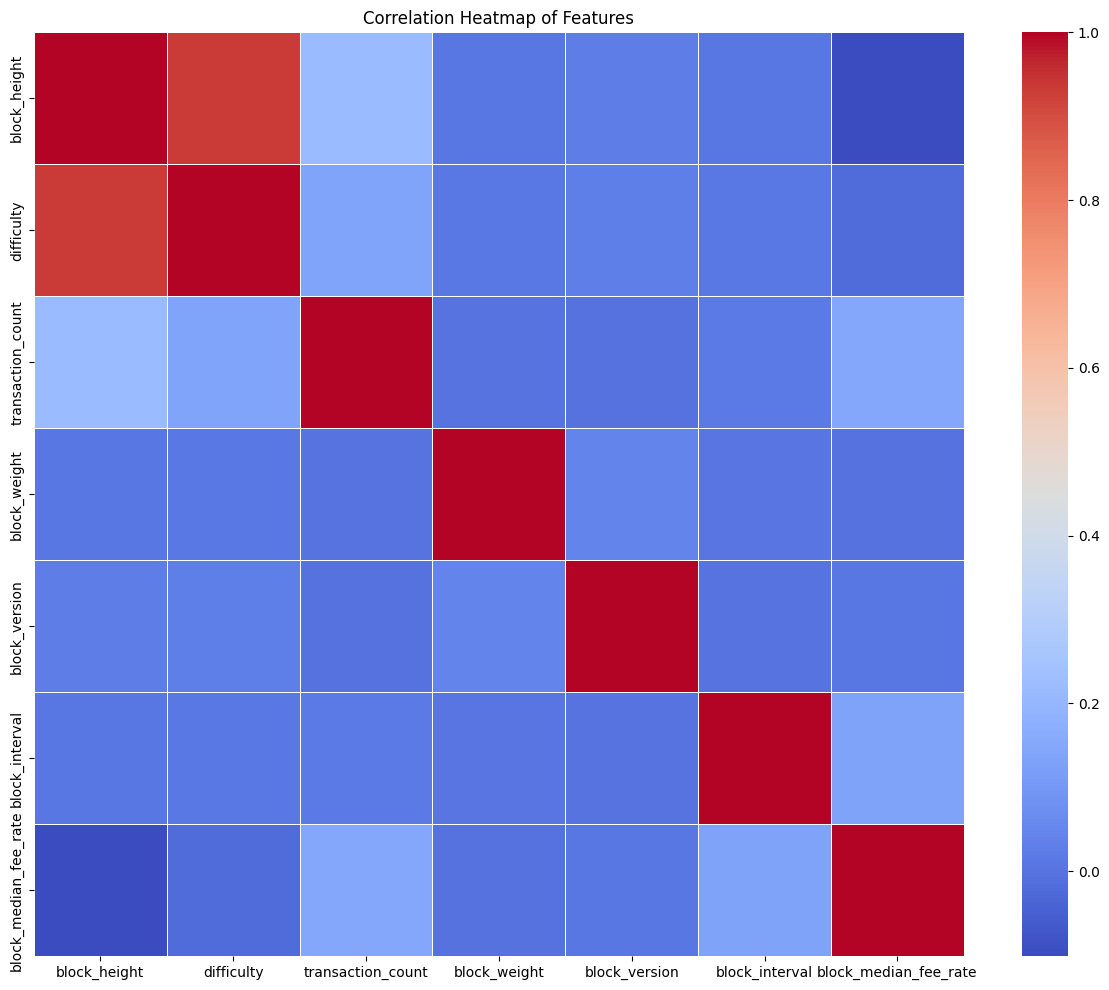

In [130]:
# Correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(sf.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()